The purpose of this code is to quantify the nuclei, the size and number of synuclein inclusions, and the lysosomal surface area in the lysotracker experiments.

Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects, binary_dilation, disk
import czifile
import skimage.io as io
from skimage import exposure
from cellpose import models
model = models.Cellpose(model_type='cyto')

c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\cellpose\resnet_torch.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(filename, 

Define Sub Functions

In [2]:
def show_image(image):
    io.imshow(image)
    plt.show()
    
def calculate_surface_area(labeled_image, channel=None):
    """Calculate the total surface area for labeled regions."""
    props = regionprops(labeled_image, channel)
    return sum(prop.area for prop in props)

def preprocess_green_channel(green_channel):
    """Preprocess the green channel for inclusion quantification."""
    confocal_img = gaussian(green_channel, sigma=2)
    confocal_img = exposure.adjust_sigmoid(green_channel, cutoff=0.25)
    confocal_img = (confocal_img - confocal_img.min()) / (confocal_img.max() - confocal_img.min())
    
    return confocal_img

def preprocess_green_channel_cellpose(green_channel):
    """Alternative to cellpose for segmenting cells?"""
    blurred_dapi = gaussian(green_channel, sigma=2)
    # threshold = threshold_multiotsu(blurred_dapi)[0]
    mask = blurred_dapi < 0.5
    blurred_dapi_no_inclusion = blurred_dapi[mask]
    threshold = threshold_multiotsu(blurred_dapi_no_inclusion)[0]
    binary_image = blurred_dapi > threshold
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def preprocess_dapi_channel(dapi_channel):
    """Preprocess the DAPI channel for nuclei quantification."""
    blurred_dapi = gaussian(dapi_channel, sigma=2)
    threshold_value = threshold_otsu(blurred_dapi)
    binary_image = blurred_dapi > threshold_value
    # show_image(binary_image)
    cleaned_image = remove_small_objects(binary_image, min_size=400)
    merged_image = binary_dilation(cleaned_image, footprint=disk(5))
    labeled_image = label(merged_image)
    return labeled_image

def count_nuclei(labeled_image):
    """Count the number of nuclei in the labeled image."""
    return len(np.unique(labeled_image)) - 1

def calculate_metrics(basename, num_inclusions,num_nuclei):
    """Calculate additional metrics and return the second DataFrame."""

    return pd.DataFrame({
        "File_Name:": [basename],
        "Number_of_Inclusions": [np.sum(num_inclusions)],
        "Number_of_Nuclei": [num_nuclei],
        "Number_of_Inclusions_per_Nucleus": [np.sum(num_inclusions) / num_nuclei],
    })



In [3]:
def analyze_image(image_path, basename):
    """
    Analyze an image by its individual cells
    Args:
        image_path: Path to the .czi image file.
        basename: Base name for the file, used in the output DataFrame.

    Returns:
        A DataFrame containing details about each image 
        A second DataFrame containing details about each detected cell
    """
    
    # Load the image and squeeze dimensions
    image = czifile.imread(image_path)
    image_squeezed = np.squeeze(image)

    # Separate the channels
    green_channel = image_squeezed[0, :, :]
    dapi_channel = image_squeezed[1, :, :]

    green_channel = preprocess_green_channel(green_channel)
    print("Green Channel")
    show_image(green_channel)

    # Process DAPI channel for nuclei counting
    labeled_image_dapi = preprocess_dapi_channel(dapi_channel)
    num_nuclei = count_nuclei(labeled_image_dapi)

    
    # show_image(green_channel_cells)
    #normalize
    green_channel = (green_channel - np.min(green_channel)) / ((np.max(green_channel) - np.min(green_channel)))
    green_channel_remove_inclusions = np.where(green_channel < 0.8, green_channel, 0)
    show_image(green_channel_remove_inclusions)
    green_channel_remove_inclusions = gaussian(green_channel_remove_inclusions, sigma=10)
    show_image(green_channel_remove_inclusions)
    # Detect cells in the green channel
    masks, flows, styles, diams = model.eval(green_channel_remove_inclusions, diameter=300, channels=[0, 0])
    labeled_cells = label(masks)
    
    # Alternative way to detect cells:
    # green_channel_cells = preprocess_green_channel_cellpose(green_channel)
    # labeled_cells = green_channel_cells
    print("Segmented Cells")
    show_image(labeled_cells)


    #threshold = threshold_multiotsu(green_channel)[1]+0.3
    # print(thresholds)
    #show_image(green_channel>threshold)
    # show_image(green_channel>0.7)
    

    # Initialize lists to store results
    cell_counter = []
    cell_size = []
    num_inclusions = []
    total_inclusion_areas = []
    average_inclusion_areas = []

    inclusion_areas_list = []
    inclusion_counter = []

    # Analyze each detected cell
    for i, cell in enumerate(regionprops(labeled_cells)):
        if cell.area < 100:
            continue
        
        cell_counter.append(i)
        cell_size.append(cell.area)
        


        mask = labeled_cells == cell.label

        
        
        blurred_mask = gaussian(green_channel, sigma=5) * mask
        applied_mask_eliminate_background = blurred_mask[blurred_mask > 0.01]
        # normalize applied_mask_eliminate_background
        applied_mask_eliminate_background = (applied_mask_eliminate_background - np.min(applied_mask_eliminate_background)) / ((np.max(applied_mask_eliminate_background) - np.min(applied_mask_eliminate_background)))

        # show_image(applied_mask)
        # Plot histogram
        # hist, bin_edges = np.histogram(applied_mask_eliminate_background, bins='fd')
        # print("Bin count", len(bin_edges))
        # q1 = np.percentile(applied_mask_eliminate_background, 25)
        # q3 = np.percentile(applied_mask_eliminate_background, 75)
        # iqr = q3 - q1
        # print("IQR: ", iqr)


        mean_intensity = np.mean(applied_mask_eliminate_background)
        
        

        
        # 0.4 is an empirical value
        if mean_intensity < 0.4:
            # there are inclusions
            threshold = max(0.8,threshold_multiotsu(applied_mask_eliminate_background)[1]) # empirical values
            print("Threshold: ", threshold)
            # plt.hist(applied_mask_eliminate_background, bins='fd')  # arguments are passed to np.histogram
            # plt.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_intensity:.2f}')

            # plt.title("Histogram with 'auto' bins")
            # plt.show()
        else:
            # no inclusions
            threshold = 1
        # print("Threshold: ", threshold)

        # normalize 
        applied_mask = green_channel * mask
        applied_mask = (applied_mask - np.min(applied_mask)) / ((np.max(applied_mask) - np.min(applied_mask))) 
        inclusions = applied_mask > threshold
        inclusions_labeled = label(inclusions)
        cell_area = cell.area
        
        
        
        inclusion_areas = [inclusion.area for inclusion in regionprops(inclusions_labeled) if inclusion.area > 10]
        inclusion_areas = np.array(inclusion_areas)
        total_inclusion_area = np.sum(inclusion_areas)
        average_inclusion_area = np.mean(inclusion_areas)
        
        # if (total_inclusion_area == 0 or 
        #     total_inclusion_area/cell_area > 0.3 or 
        #     np.any(inclusion_areas>max(cell_area*0.3,2000)) or
        #     average_inclusion_area/cell_area > 0.1): 
        #     # cells that seem to have abnormally large inclusions after thresholding actually have no inclusions.
        #     num_inclusions.append(0)
        #     total_inclusion_areas.append(0)
        #     average_inclusion_areas.append(0)
        #     continue

        # print('Cell: ', i)
        # print('Inclusion Area', total_inclusion_area)
        # print('Max Inclusion Area:',np.max(inclusion_areas))
        # print('Cell Area:', cell_area)
        # print('Ratio:', total_inclusion_area/cell_area)
        # print('Max Inclusion/Cell Area:', np.max(inclusion_areas)/cell_area)
        # print('Average Inclusion/Cell Area', average_inclusion_area/cell_area)


        if len(inclusion_areas) > 0:
            print("Inclusion Areas: ", inclusion_areas)
            show_image(inclusions)
            
        

        total_inclusion_areas.append(total_inclusion_area)
        
   

        num_inclusions.append(len(inclusion_areas))

        inclusion_areas_list.append(inclusion_areas)
        inclusion_counter.append(range(len(inclusion_areas)))

        average_inclusion_areas.append(average_inclusion_area)
    
    df1 = calculate_metrics(basename, num_inclusions,num_nuclei)
    
    df2 = pd.DataFrame({
        "File_Name": [basename] * len(cell_counter),
        "Cell": cell_counter,
        "Num_Inclusions": num_inclusions
    })
    if len(inclusion_counter) == 0:
        df3 = pd.DataFrame()
    else:
        df3 = pd.DataFrame({
            "File_Name": [basename] * len(np.concatenate(inclusion_counter)),
            "Inclusion": np.concatenate(inclusion_counter),
            "Inclusion_Area": np.concatenate(inclusion_areas_list)
        })

    
    return df1, df2, df3


In [4]:
def analyze_all_images(image_folder):
    all_data_1 = []
    all_data_2 = []
    all_data_3 = []
    for well_image in os.listdir(image_folder):
        
        if well_image.lower().endswith(".czi"):  # Filter for CZI files
            
            print(well_image)

            well_image_path = os.path.join(image_folder, well_image)
            well_image_base_name = os.path.basename(well_image)[:-4]
            
            df1, df2, df3 = analyze_image(well_image_path, well_image_base_name)
            all_data_1.append(df1)
            all_data_2.append(df2)
            all_data_3.append(df3)
            
            print("-" * 200)

    combined_df_1 = pd.concat(all_data_1, ignore_index=True)
    combined_df_1.to_excel(f"{image_folder[:6]}_analysis_by_image_NEW.xlsx", index=False)

    combined_df_2 = pd.concat(all_data_2, ignore_index=True)
    combined_df_2.to_excel(f"{image_folder[:6]}_analysis_by_cell_NEW.xlsx", index=False)

    combined_df_3 = pd.concat(all_data_3, ignore_index=True)
    combined_df_3.to_excel(f"{image_folder[:6]}_analysis_by_inclusion_NEW.xlsx", index=False)

Define Main Function

1K_ADAMTS19_01.czi
Green Channel


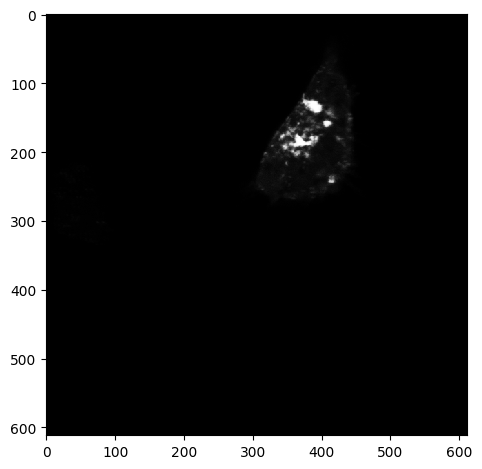

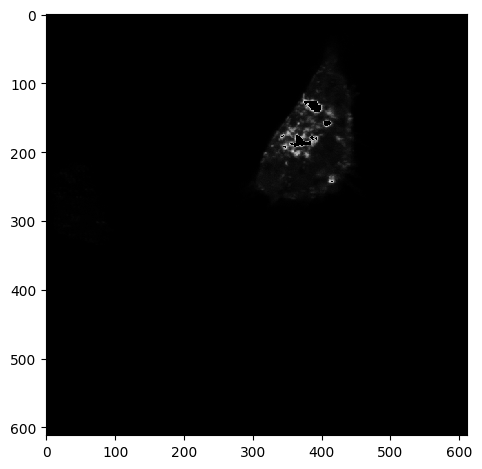

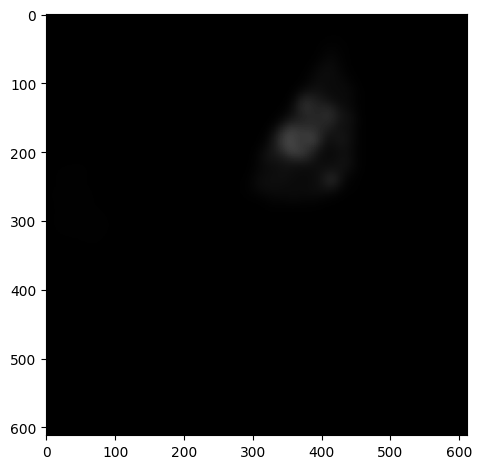

Segmented Cells


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


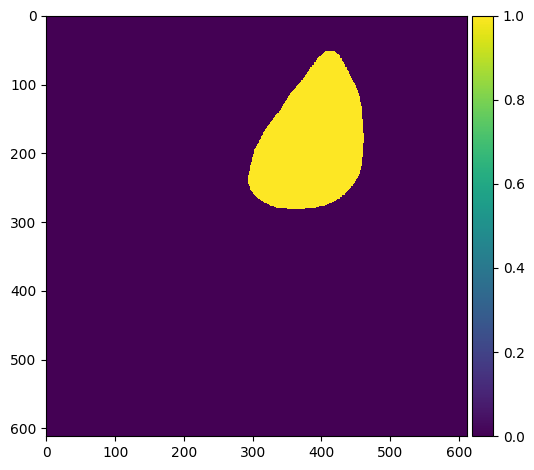

Threshold:  0.8
Inclusion Areas:  [257.  61. 224.  15.  11.]


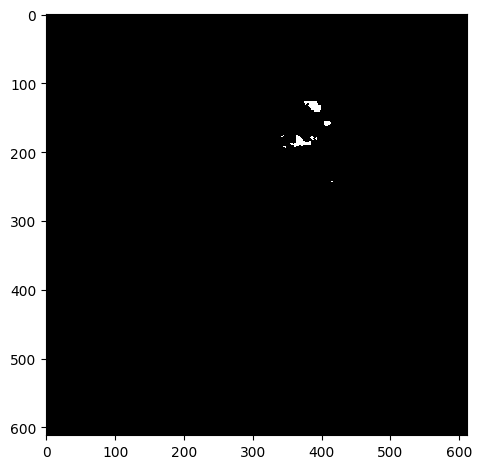

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_02.czi
Green Channel


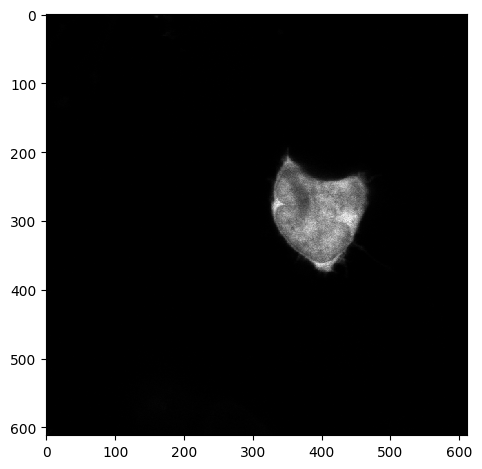

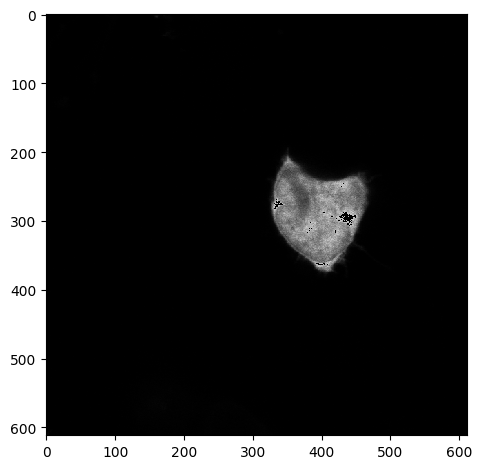

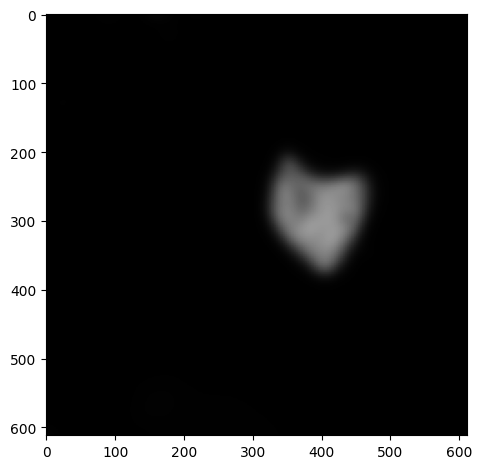

Segmented Cells


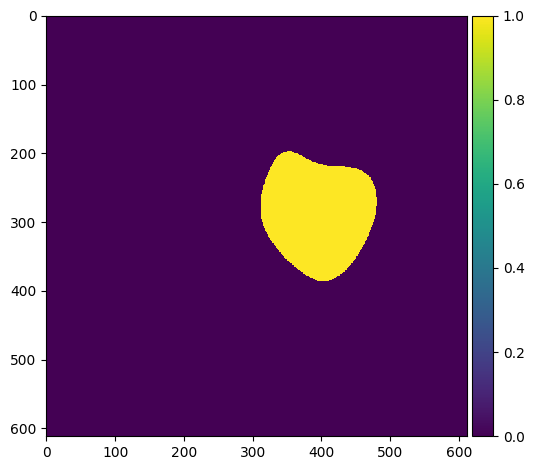

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_03.czi
Green Channel


c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yh1024\Documents\Yiming Huang\.venv\Lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


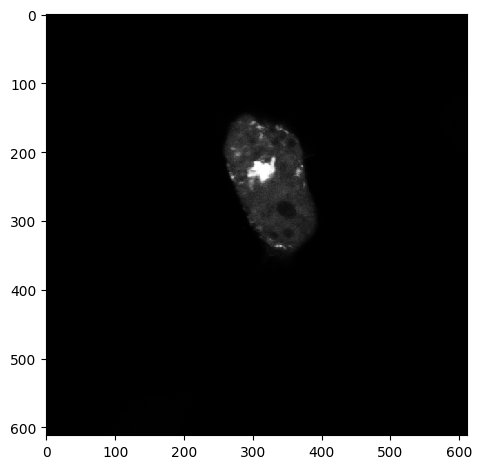

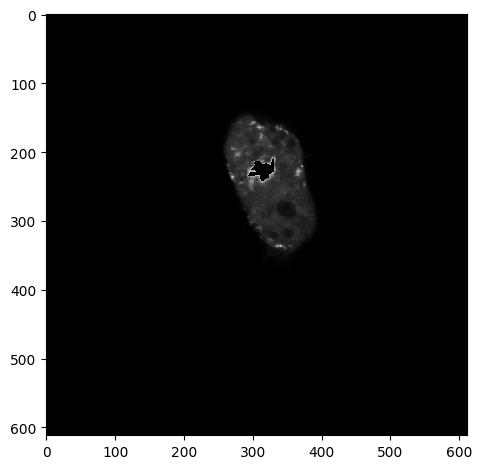

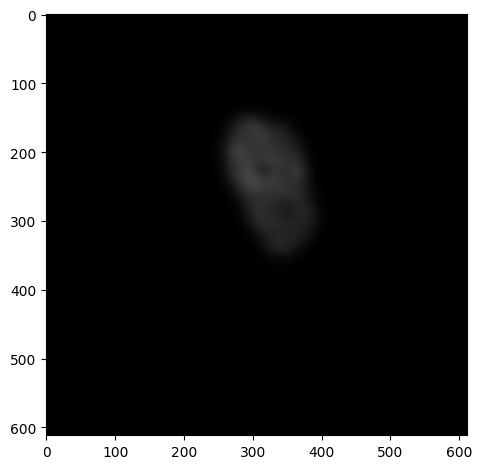

Segmented Cells


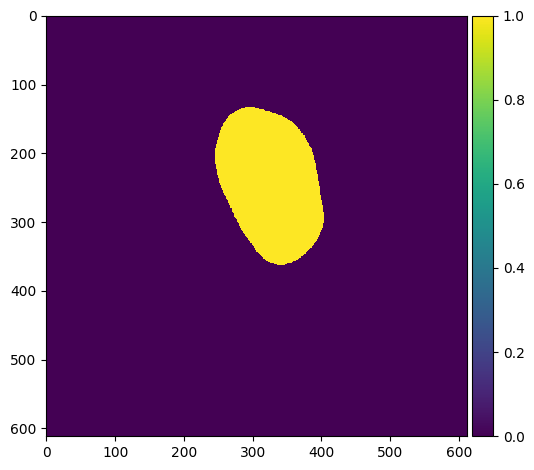

Threshold:  0.8
Inclusion Areas:  [629.]


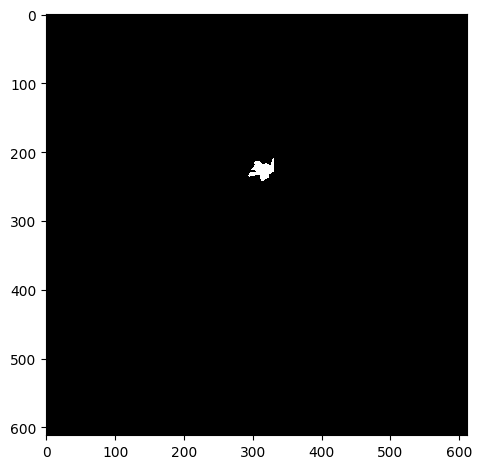

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_04.czi
Green Channel


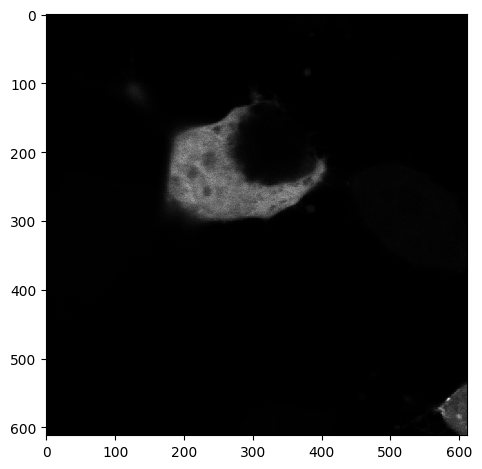

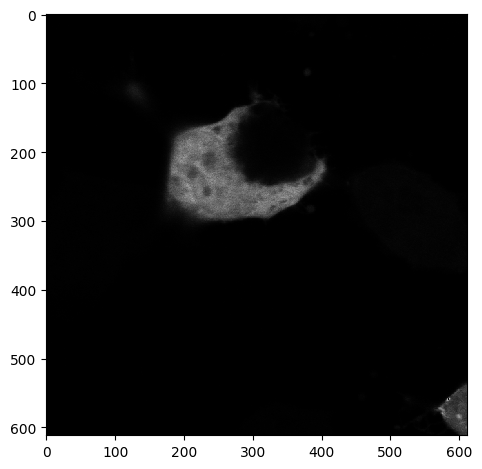

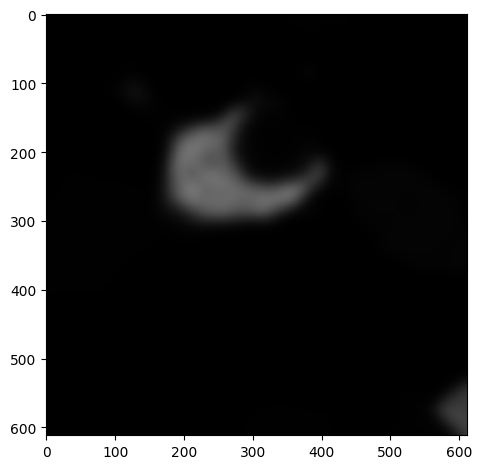

Segmented Cells


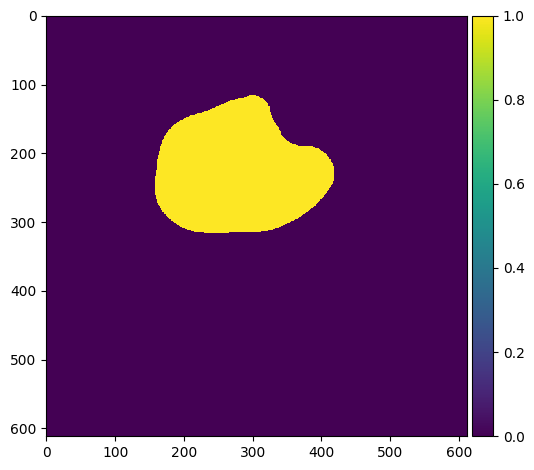

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_05.czi
Green Channel


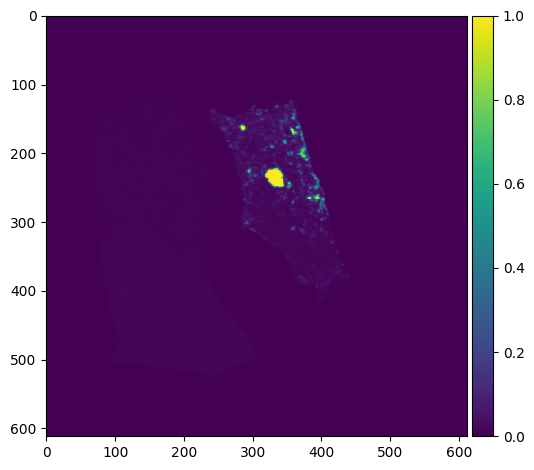

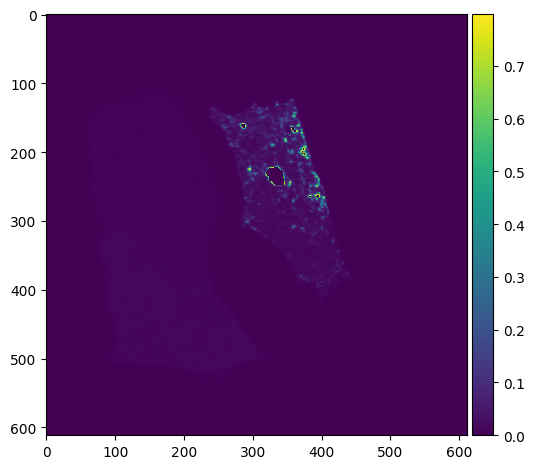

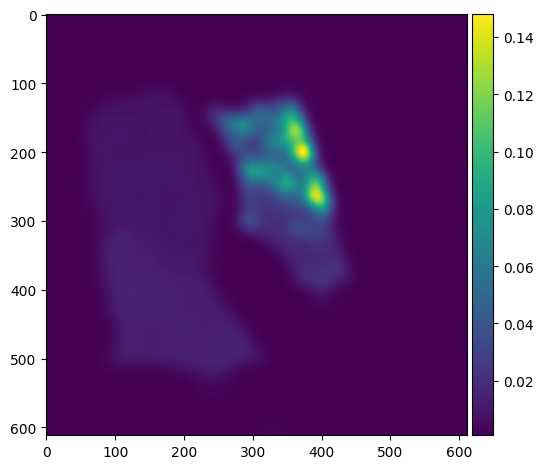

Segmented Cells


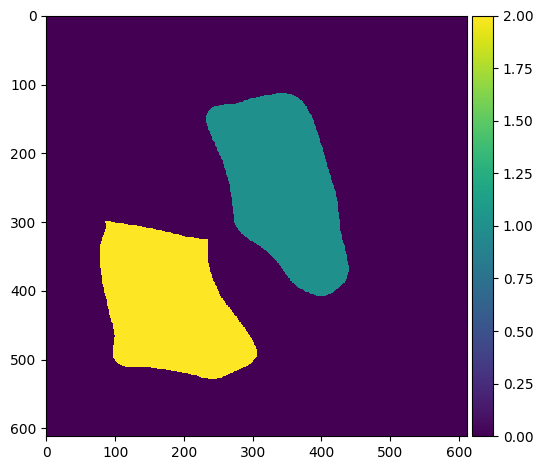

Threshold:  0.8
Inclusion Areas:  [ 30.  23.  14. 493.  15.]


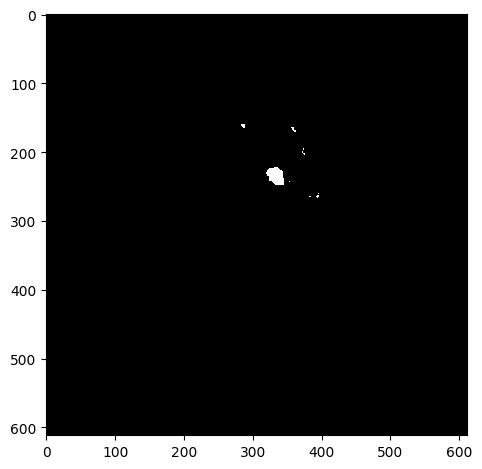

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_06.czi
Green Channel


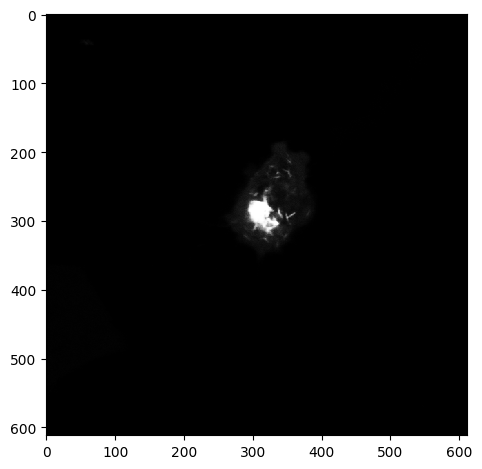

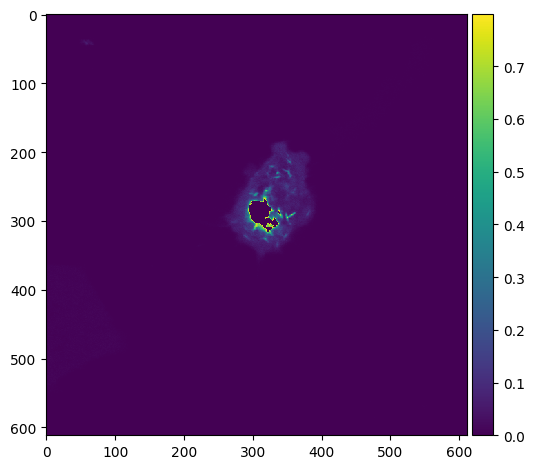

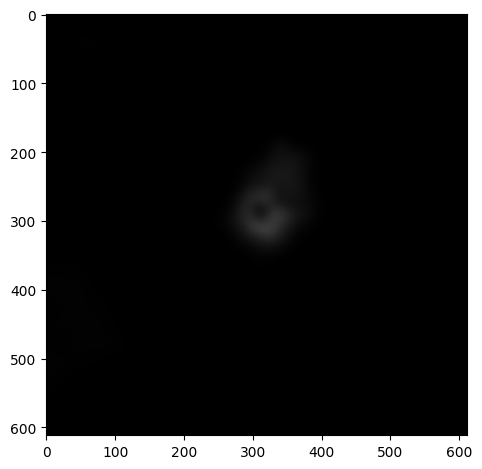

Segmented Cells


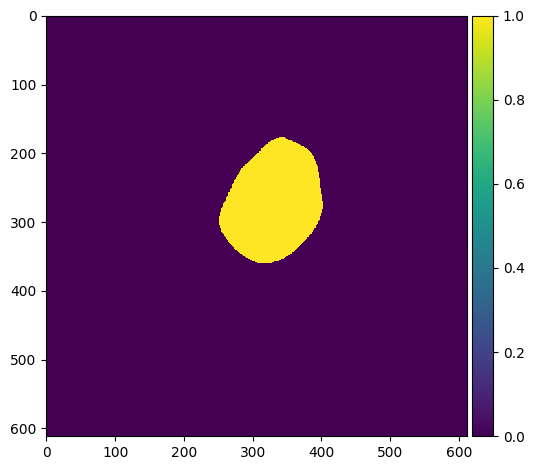

Threshold:  0.8
Inclusion Areas:  [1024.]


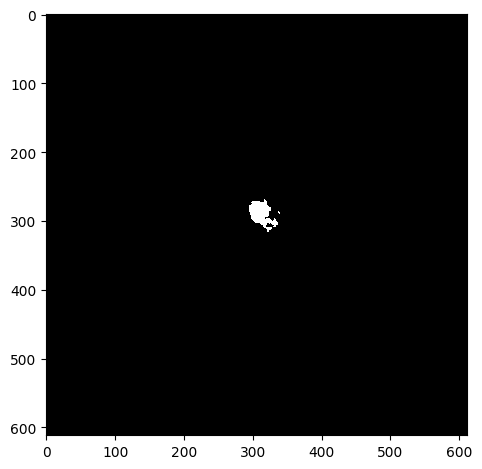

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_07.czi
Green Channel


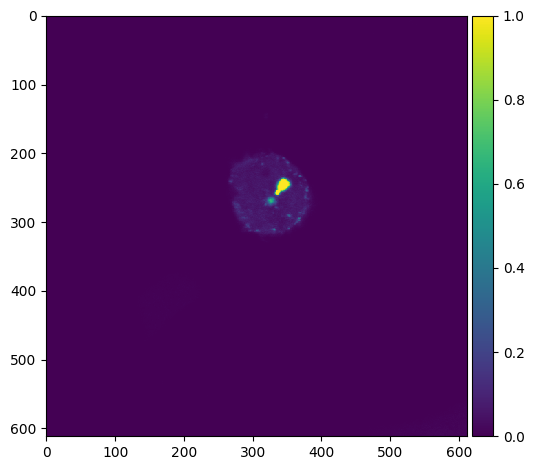

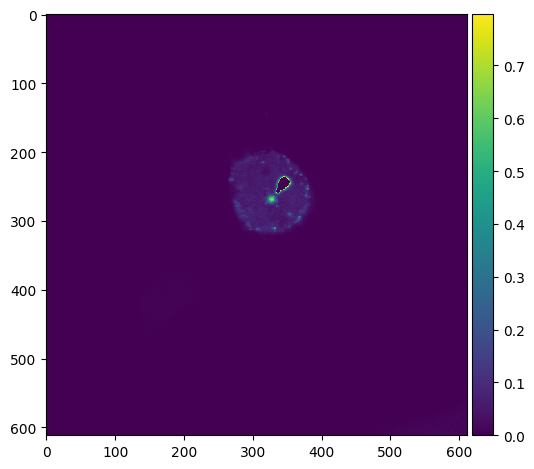

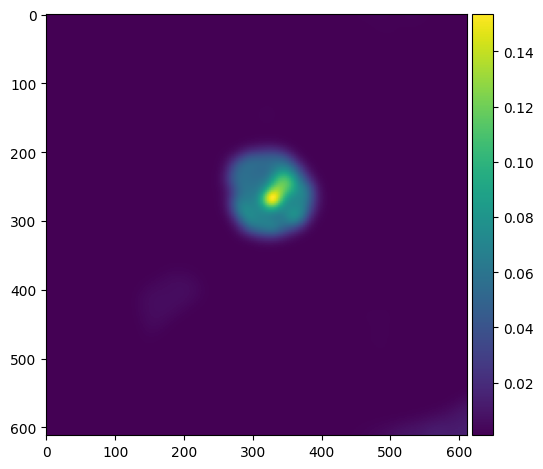

Segmented Cells


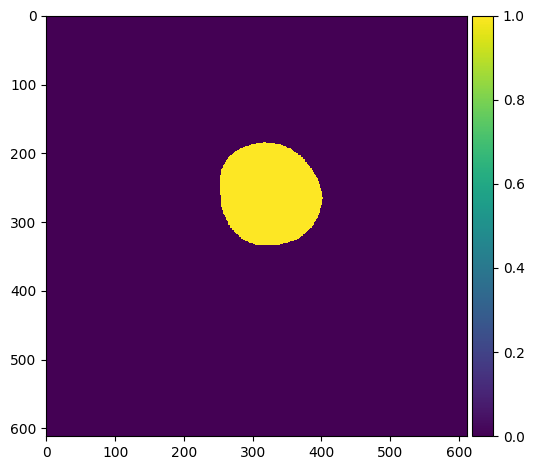

Threshold:  0.8
Inclusion Areas:  [253.]


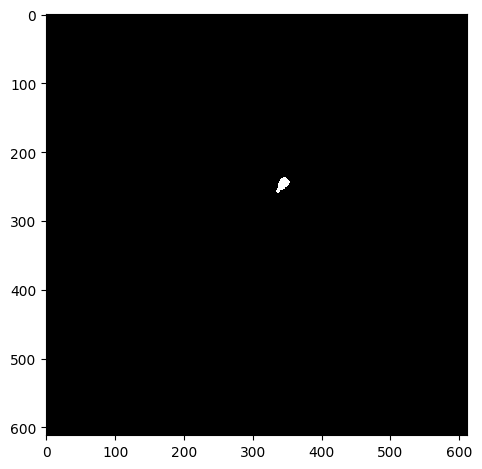

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_08.czi
Green Channel


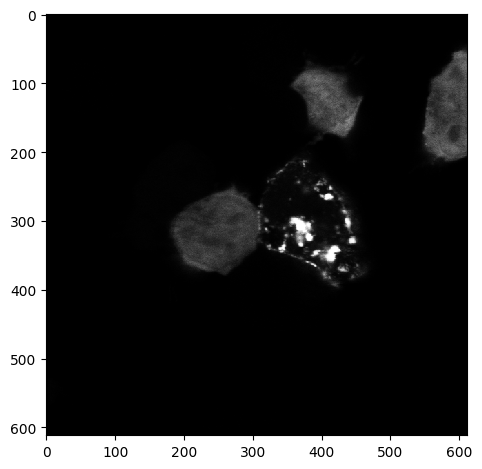

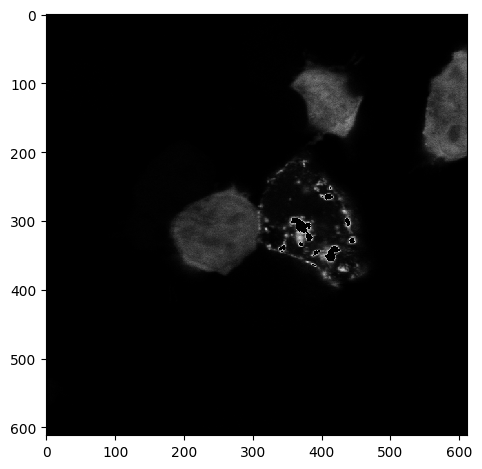

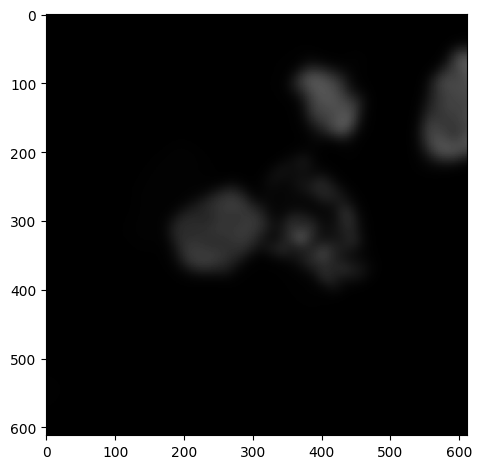

Segmented Cells


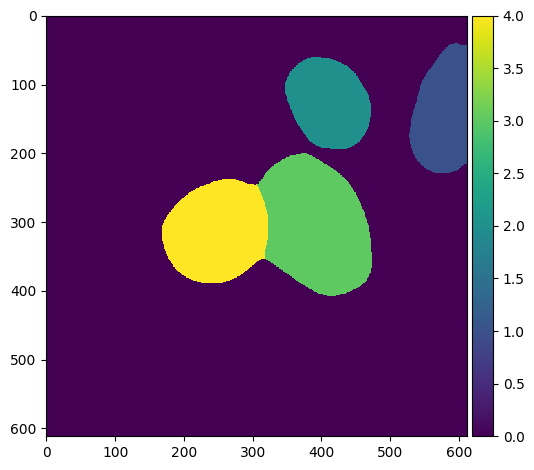

Threshold:  0.8
Inclusion Areas:  [ 77. 412.  56.  39.  25.  38. 249.  42.]


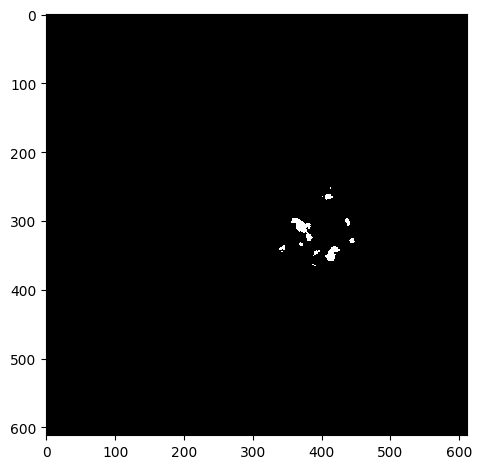

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_09.czi
Green Channel


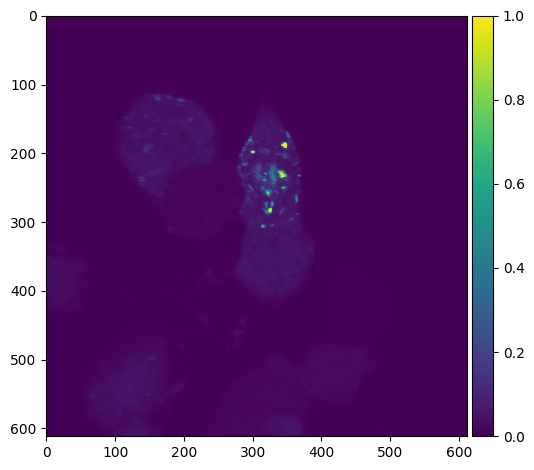

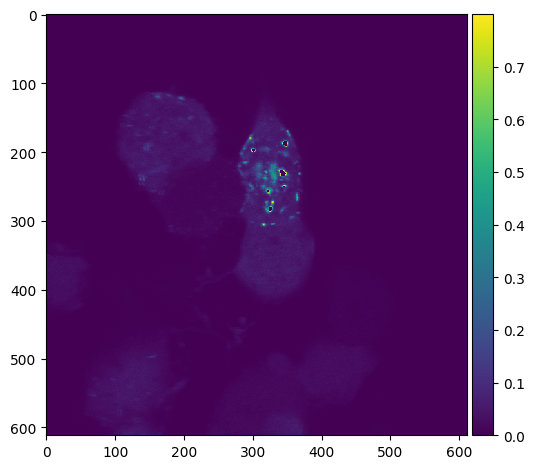

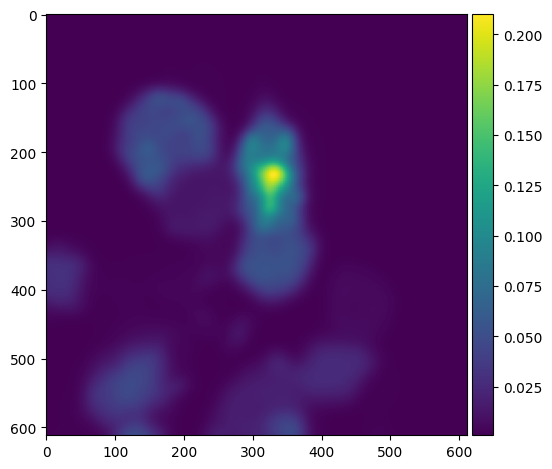

Segmented Cells


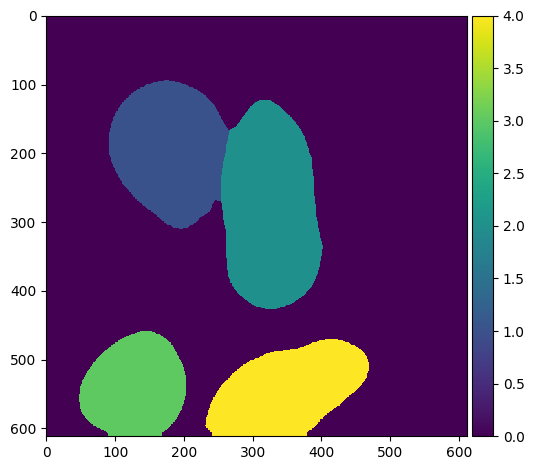

Threshold:  0.8
Threshold:  0.8
Inclusion Areas:  [40. 15. 48. 20.]


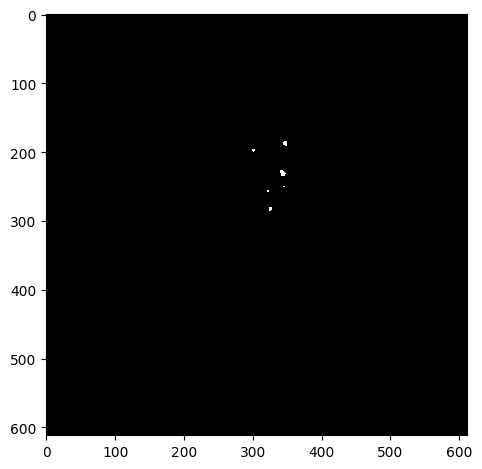

Threshold:  0.8
Inclusion Areas:  [73.]


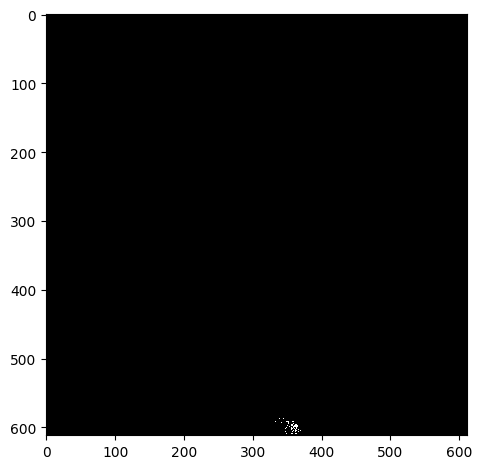

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_ADAMTS19_10.czi
Green Channel


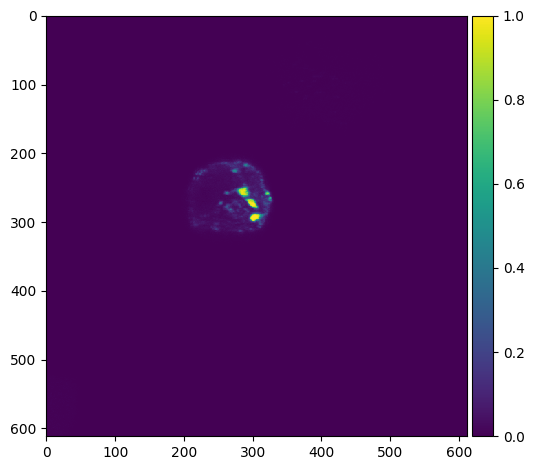

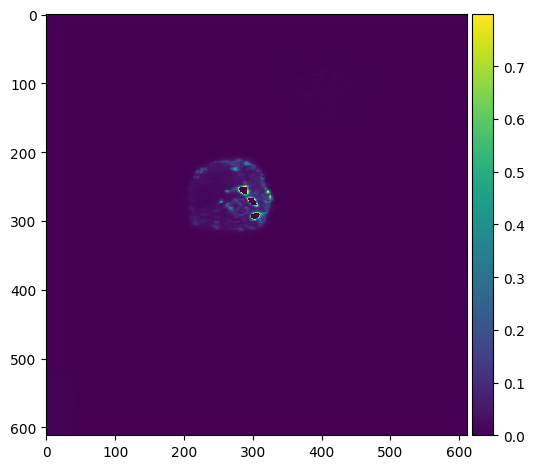

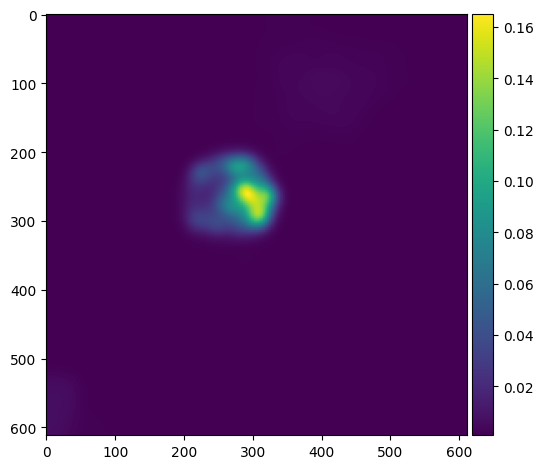

Segmented Cells


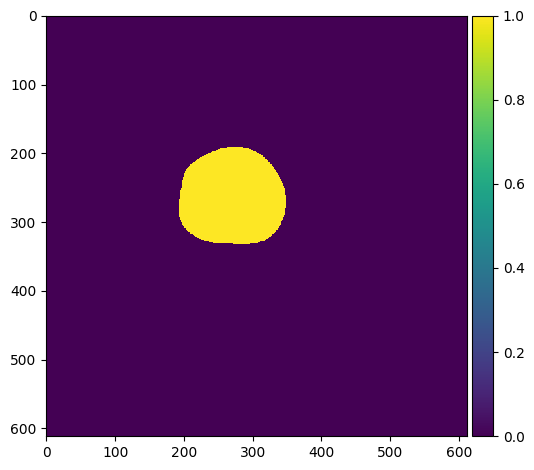

Threshold:  0.8
Inclusion Areas:  [91. 89. 86.]


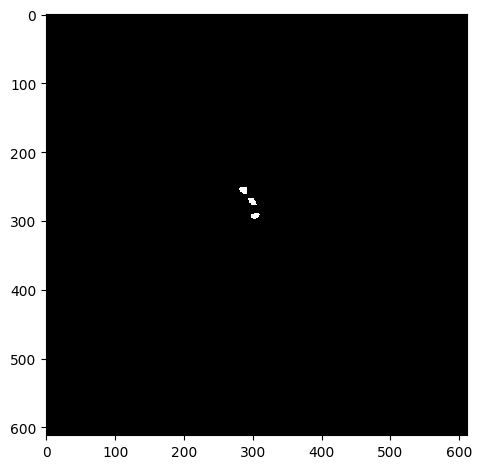

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_01.czi
Green Channel


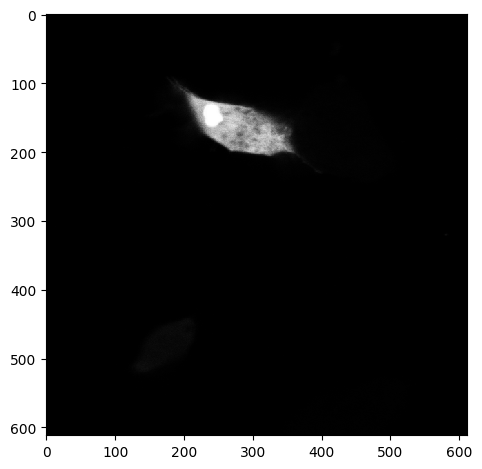

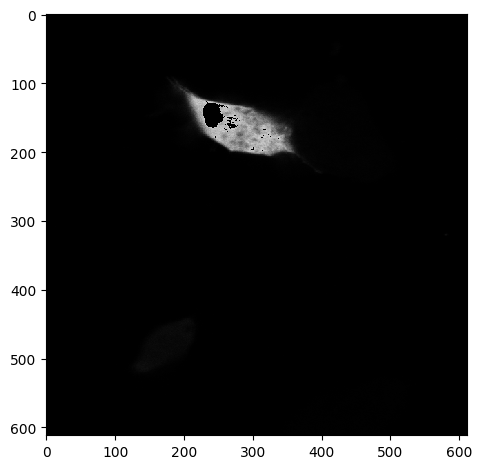

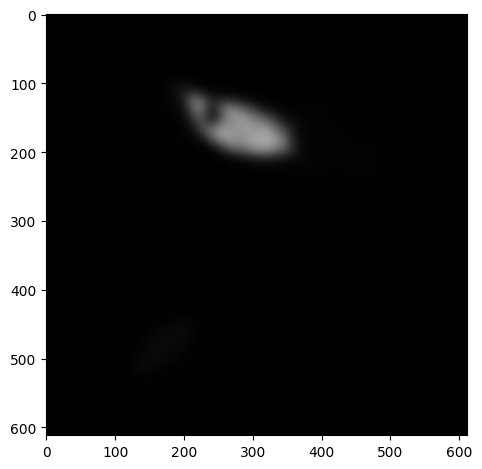

Segmented Cells


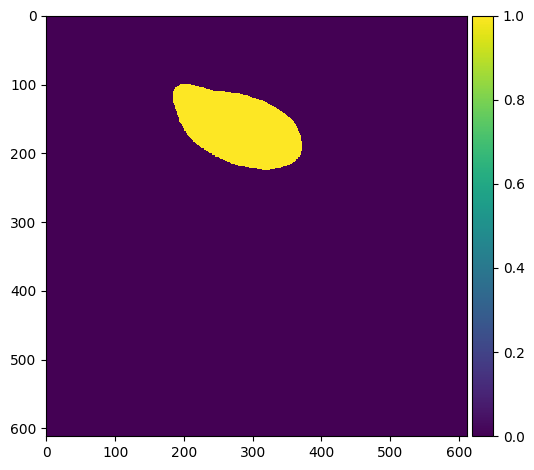

Threshold:  0.8
Inclusion Areas:  [837. 109.  11.]


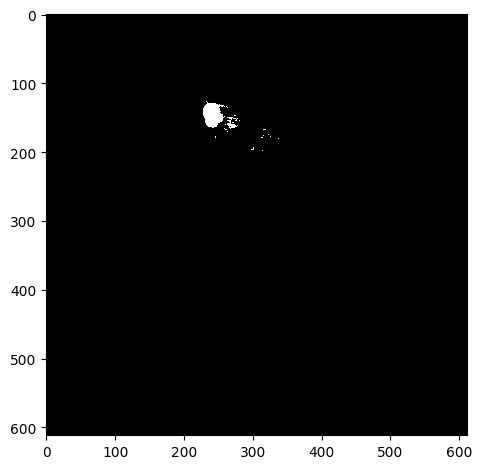

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_02.czi
Green Channel


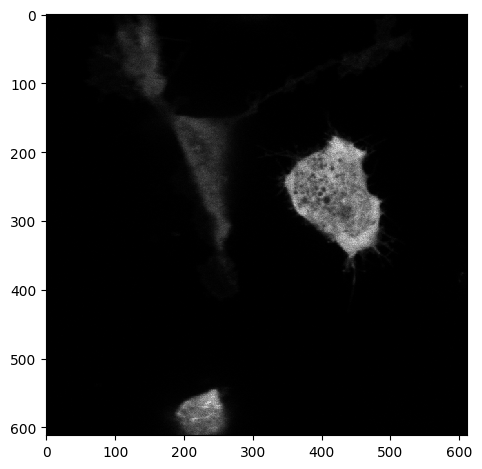

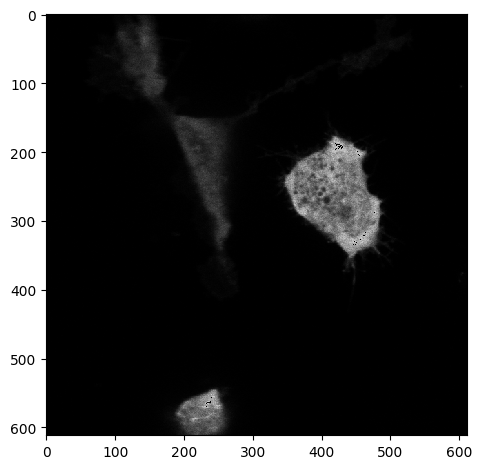

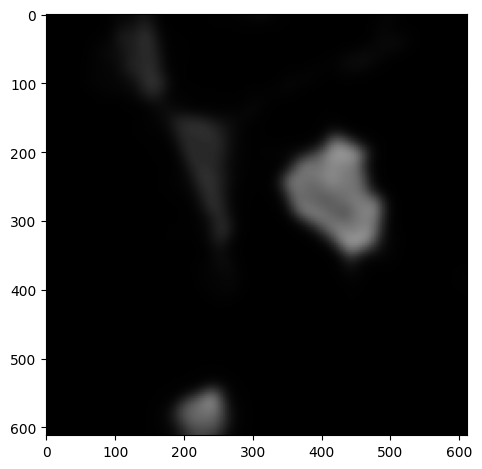

Segmented Cells


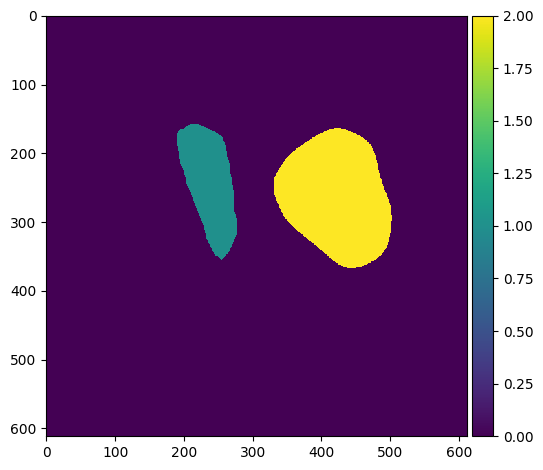

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_03.czi
Green Channel


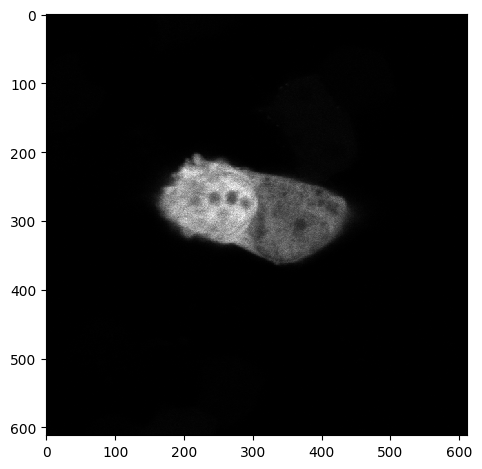

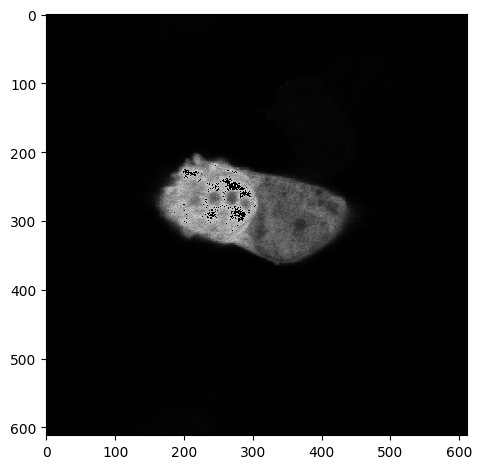

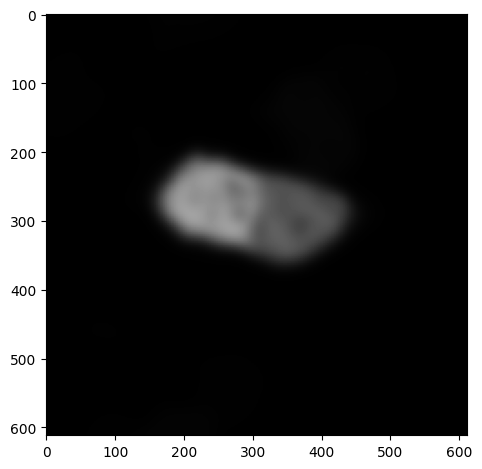

Segmented Cells


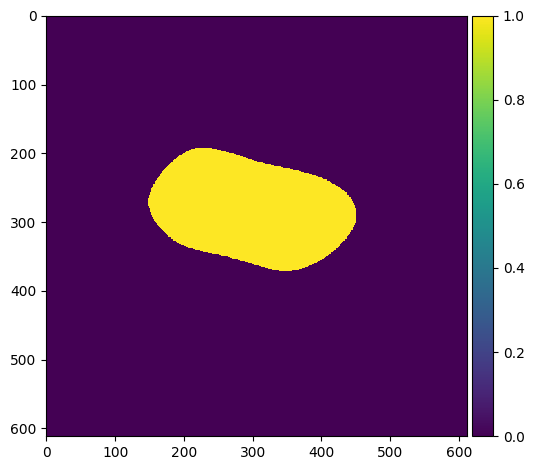

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_04.czi
Green Channel


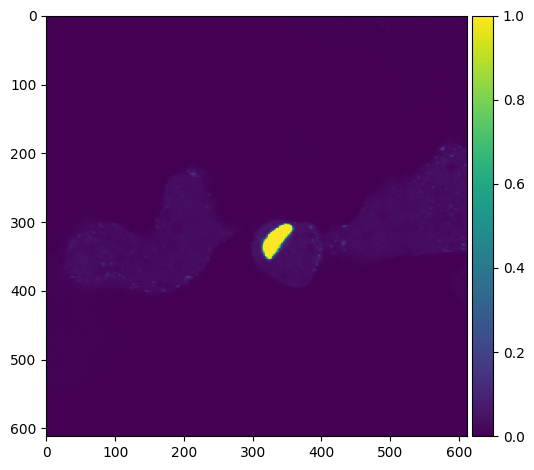

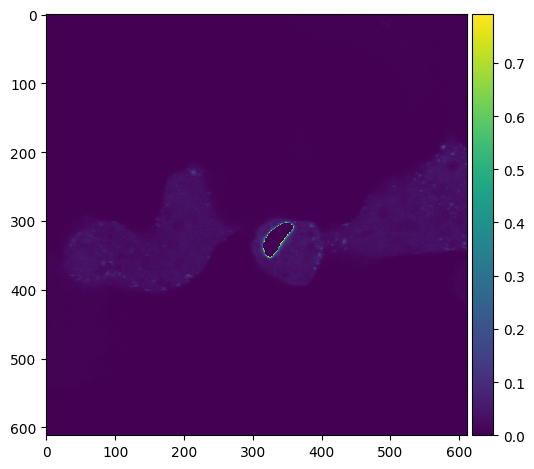

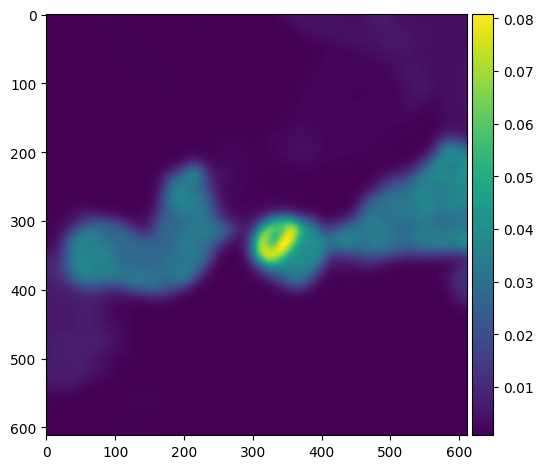

Segmented Cells


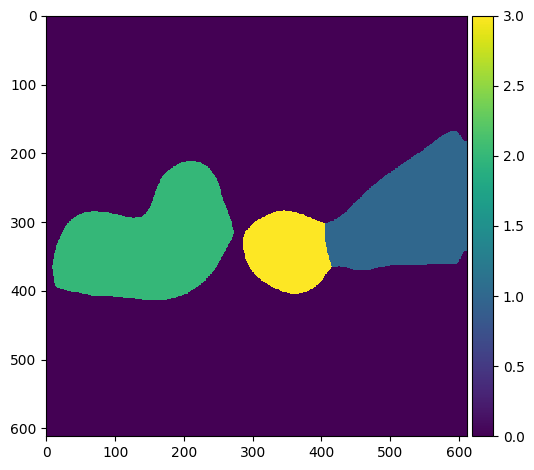

Threshold:  0.8
Inclusion Areas:  [1069.]


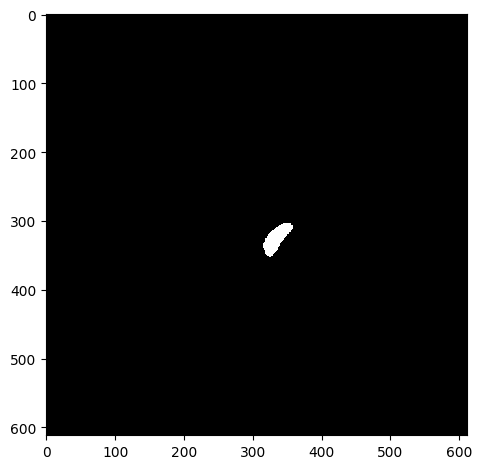

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_05.czi
Green Channel


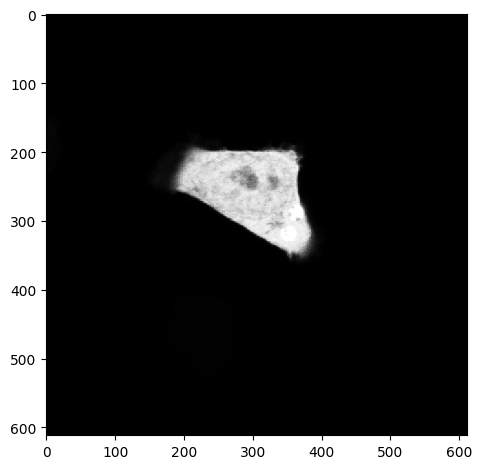

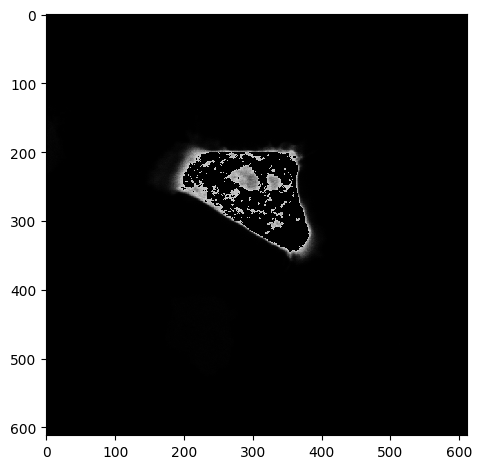

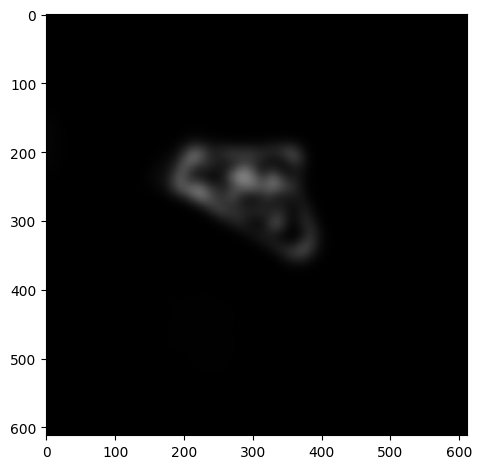

Segmented Cells


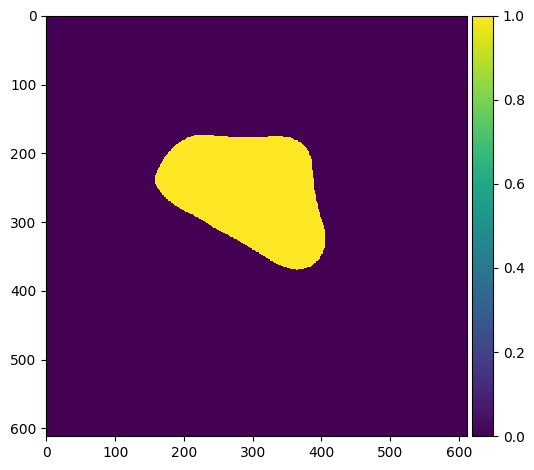

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_06.czi
Green Channel


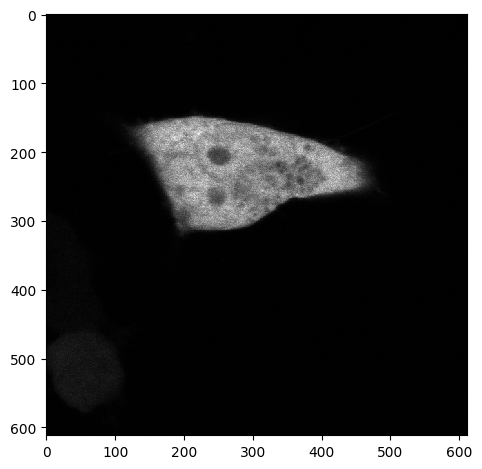

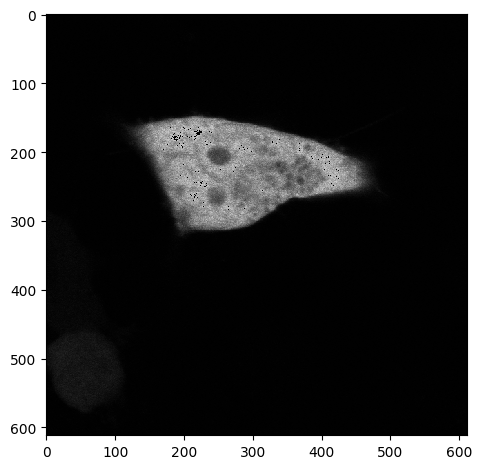

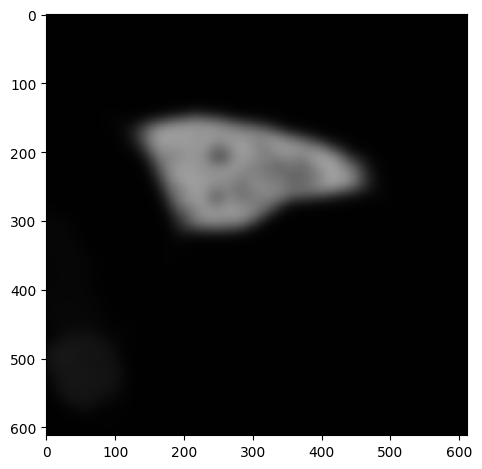

Segmented Cells


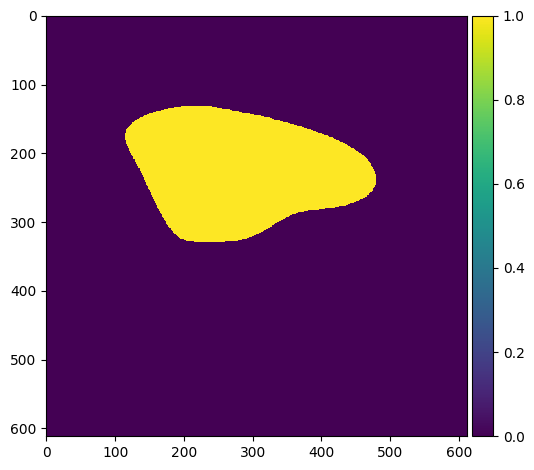

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_07.czi
Green Channel


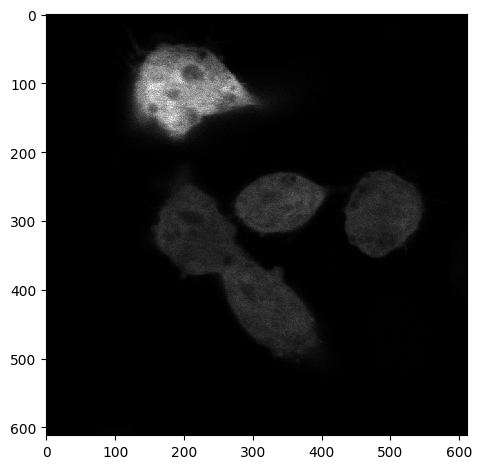

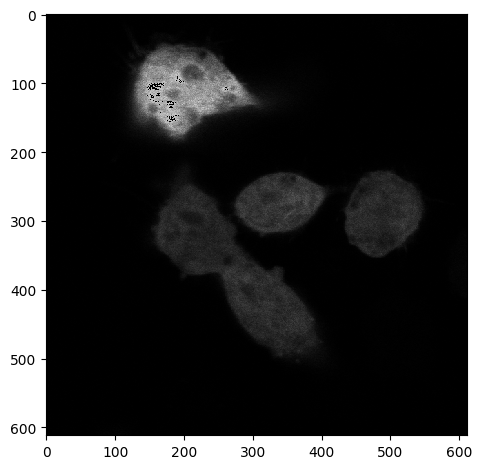

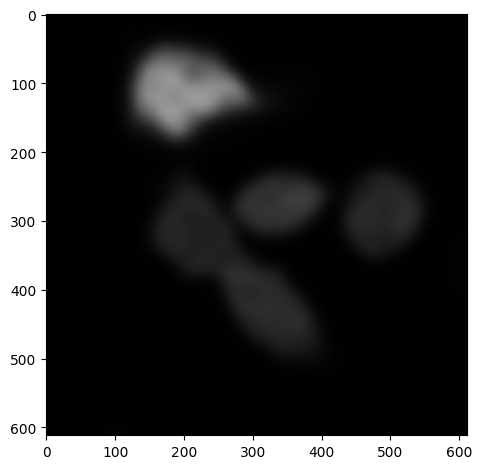

Segmented Cells


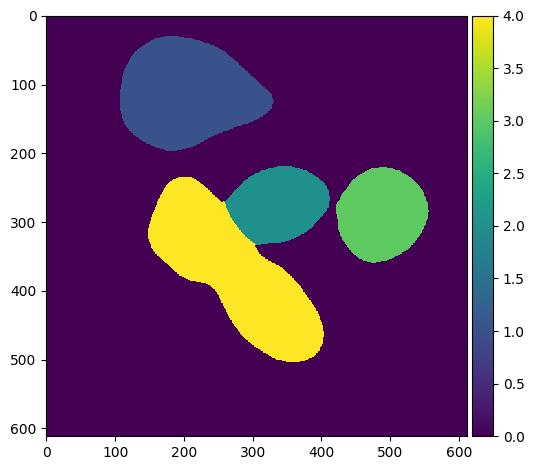

Threshold:  0.8
Inclusion Areas:  [81. 13. 14. 34. 31.]


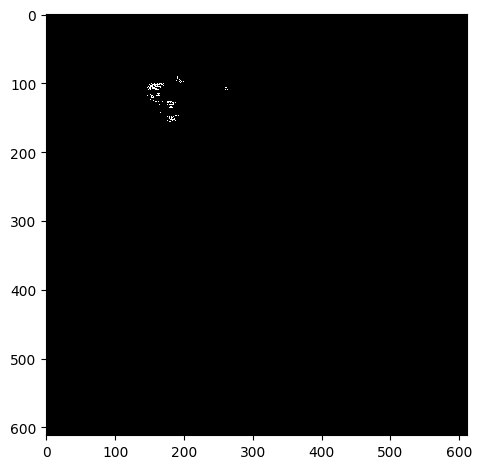

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_08.czi
Green Channel


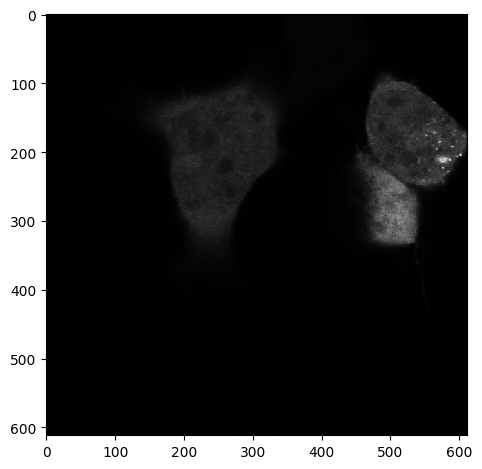

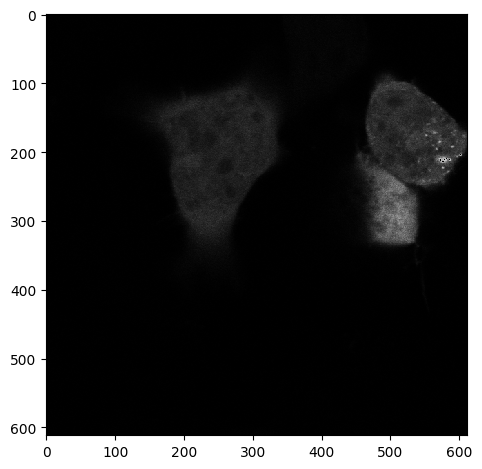

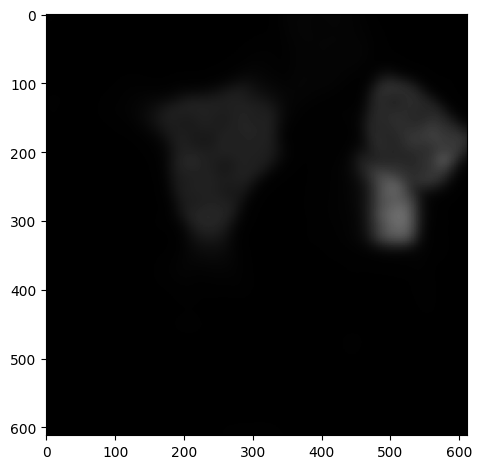

Segmented Cells


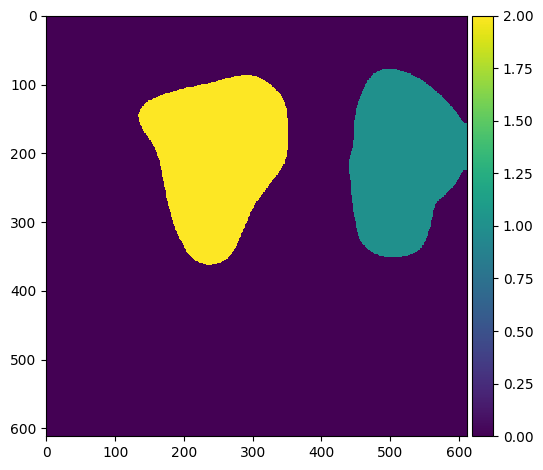

Threshold:  0.8
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_09.czi
Green Channel


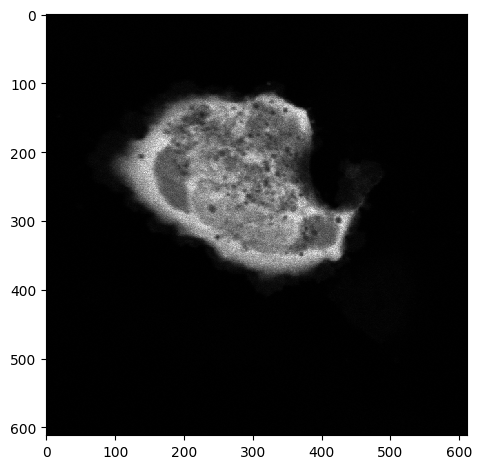

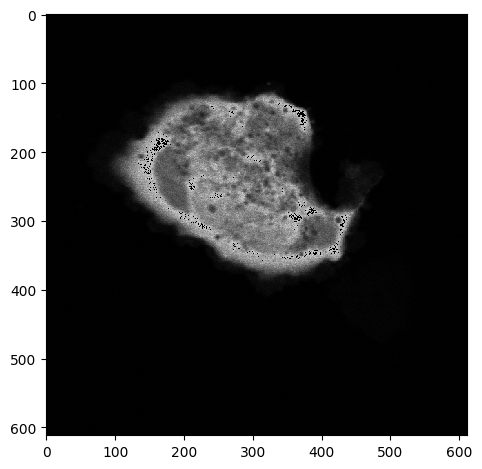

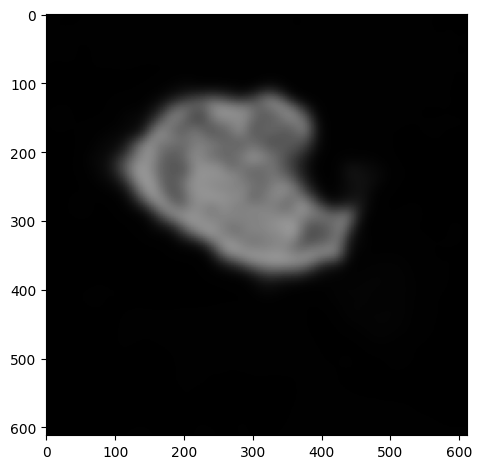

Segmented Cells


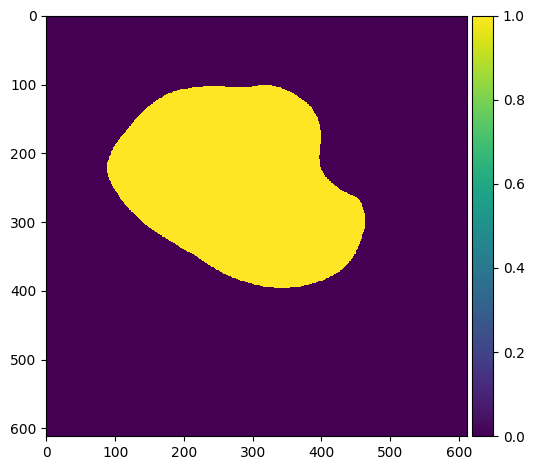

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_SCR_10.czi
Green Channel


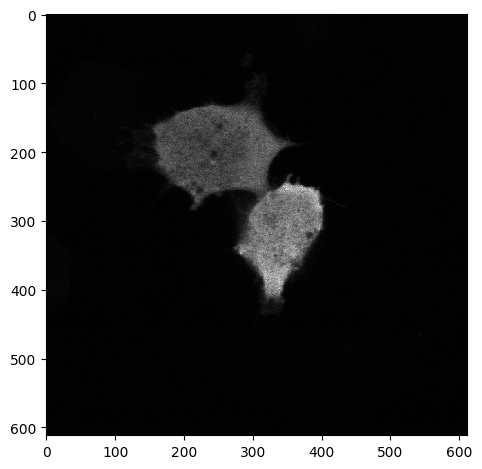

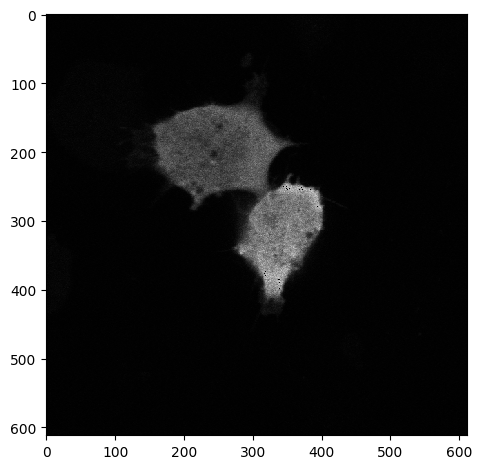

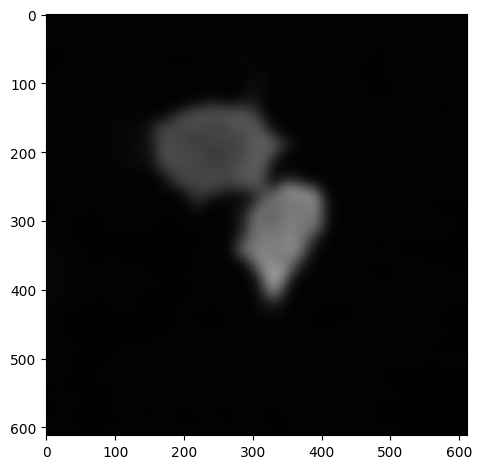

Segmented Cells


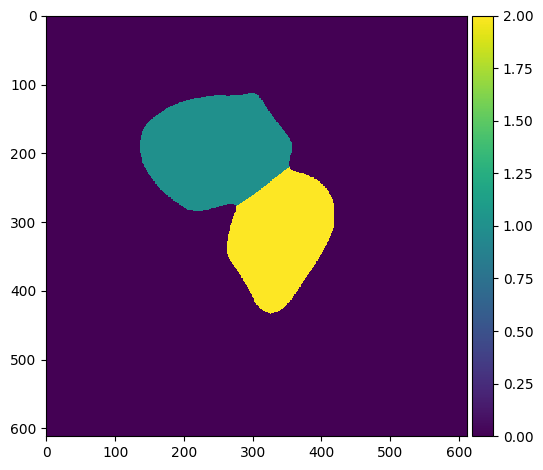

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_01.czi
Green Channel


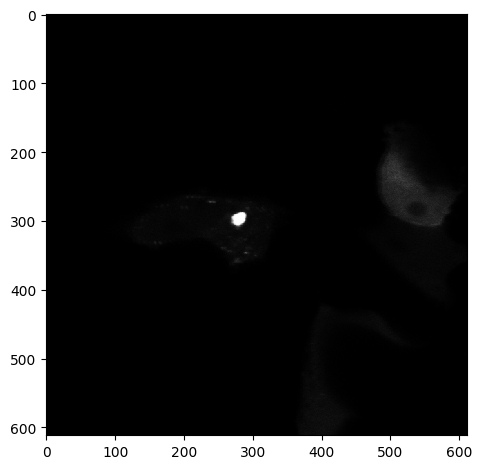

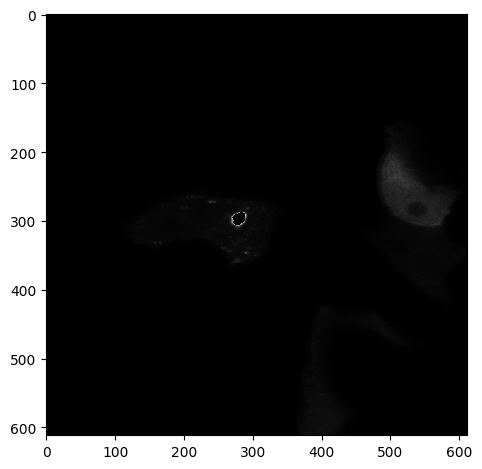

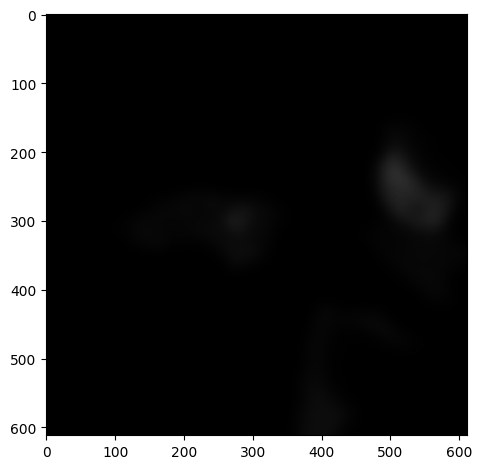

Segmented Cells


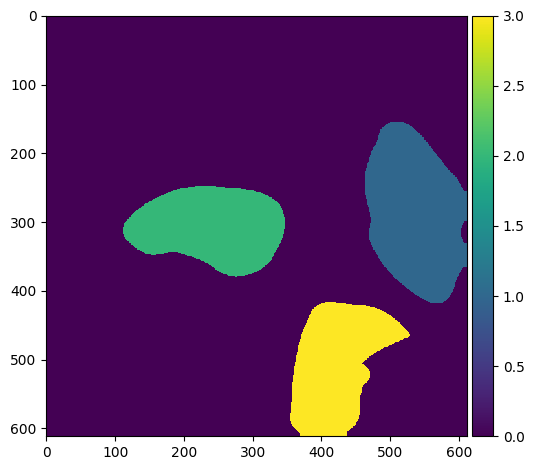

Threshold:  0.8
Inclusion Areas:  [34.]


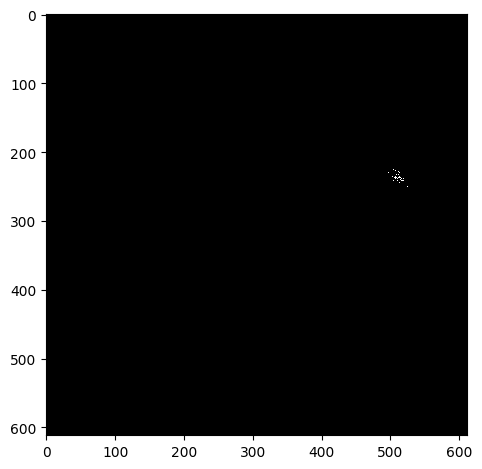

Threshold:  0.8
Inclusion Areas:  [267.]


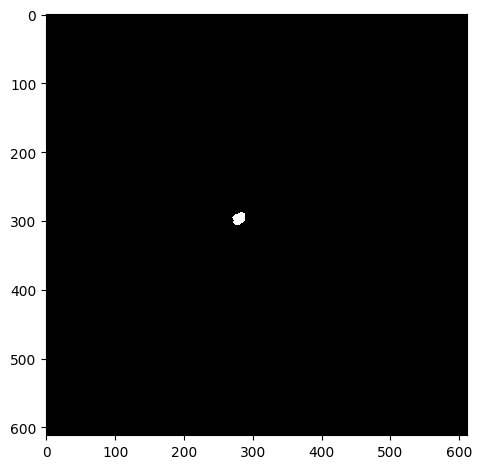

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_02.czi
Green Channel


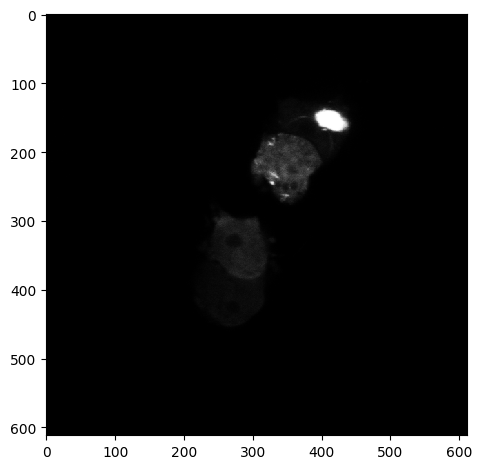

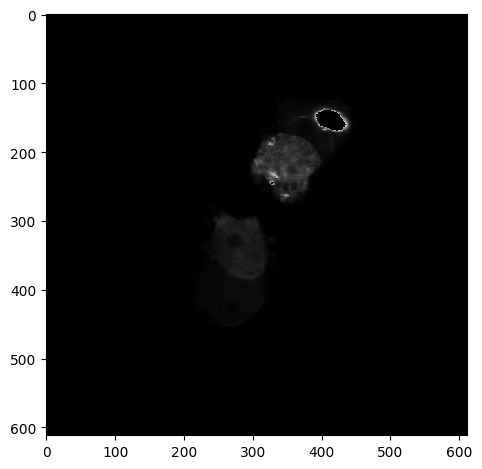

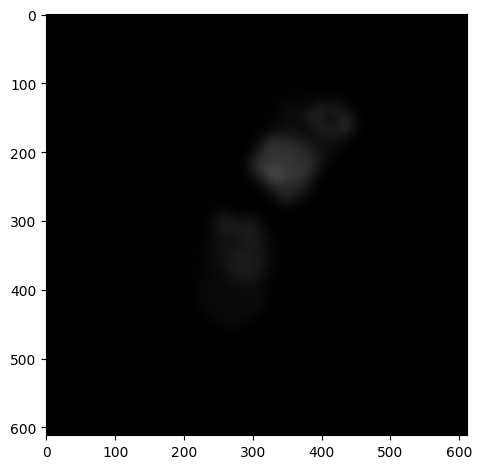

Segmented Cells


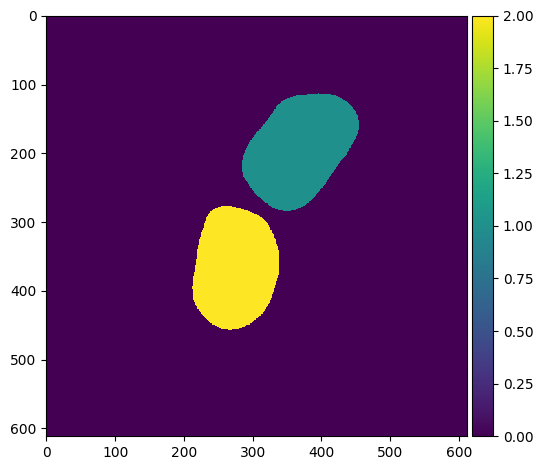

Threshold:  0.8
Inclusion Areas:  [898.]


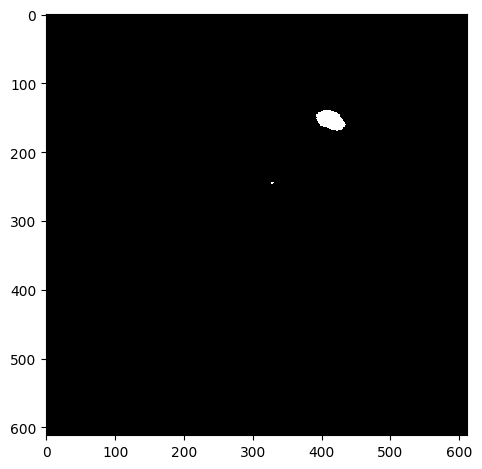

Threshold:  0.8
Inclusion Areas:  [45.]


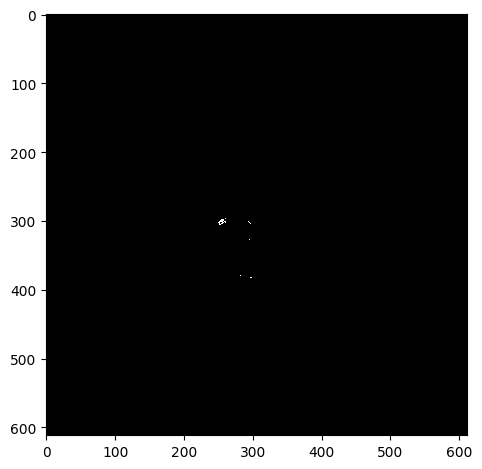

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_03.czi
Green Channel


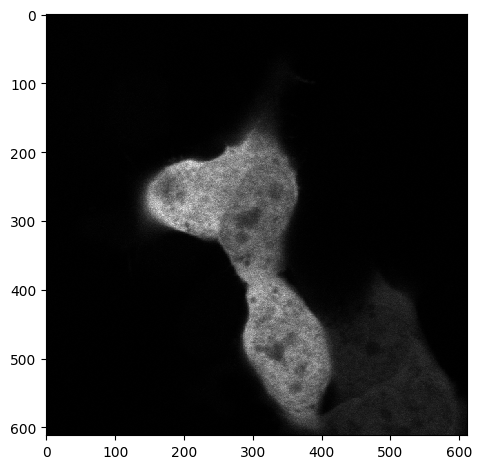

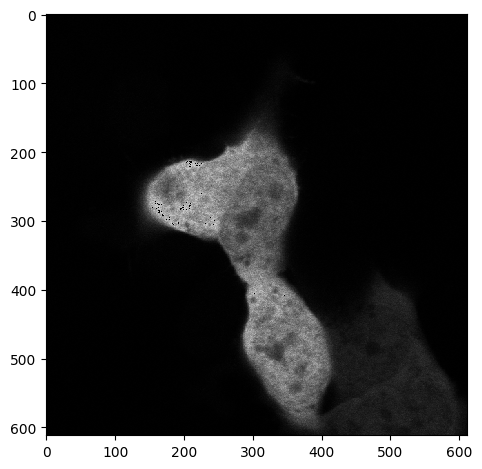

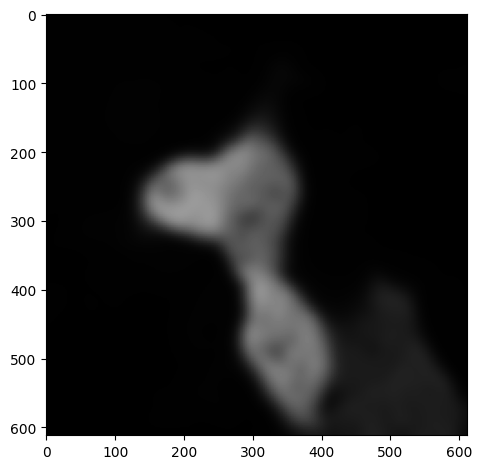

Segmented Cells


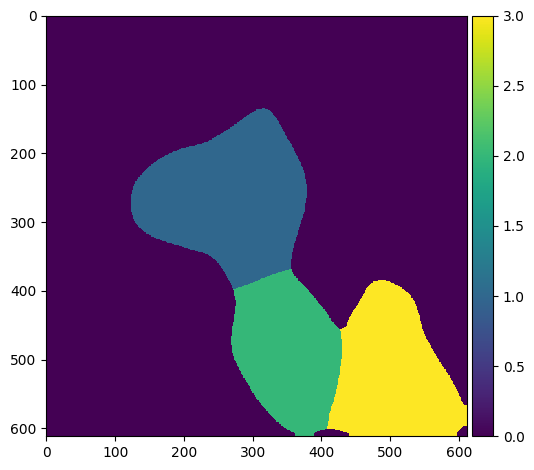

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_04.czi
Green Channel


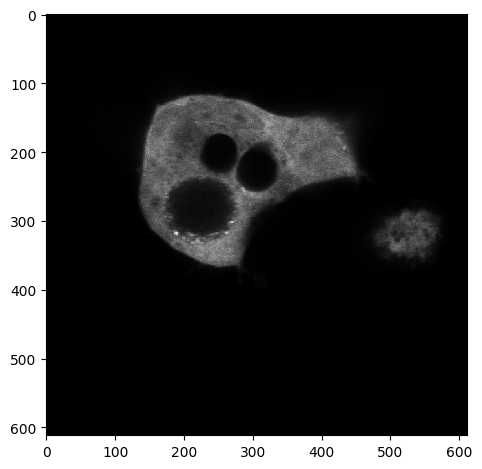

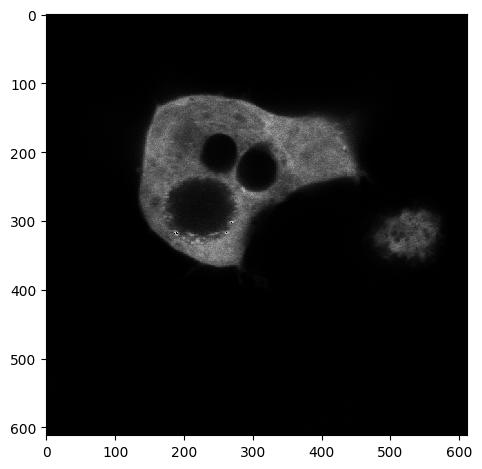

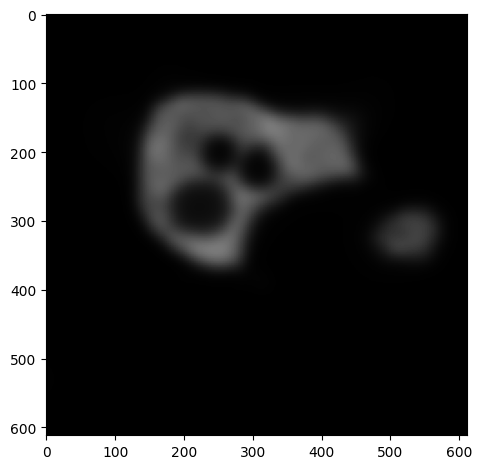

Segmented Cells


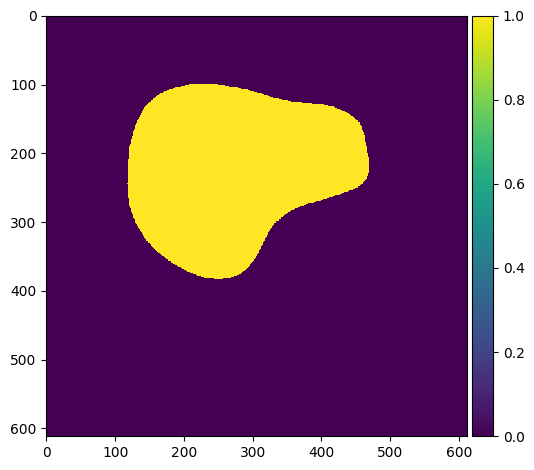

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_05.czi
Green Channel


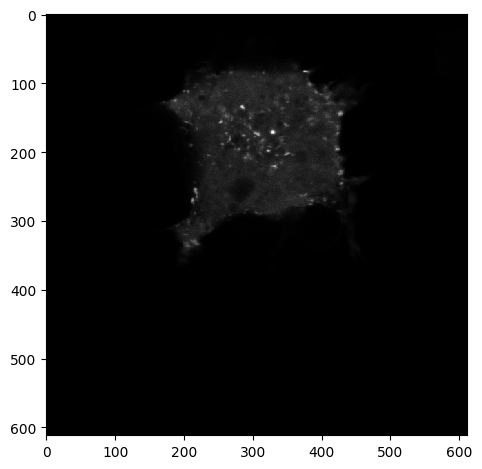

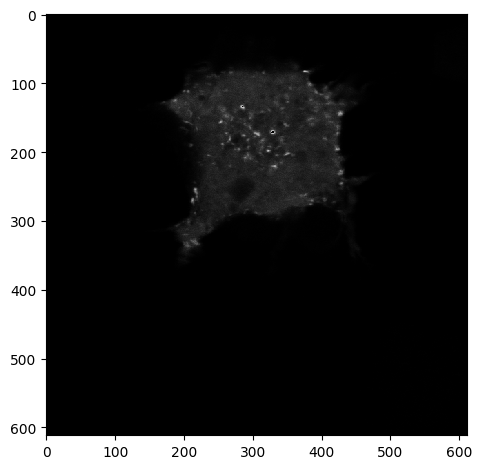

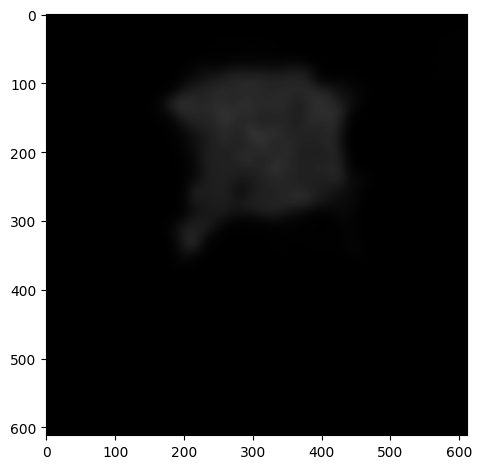

Segmented Cells


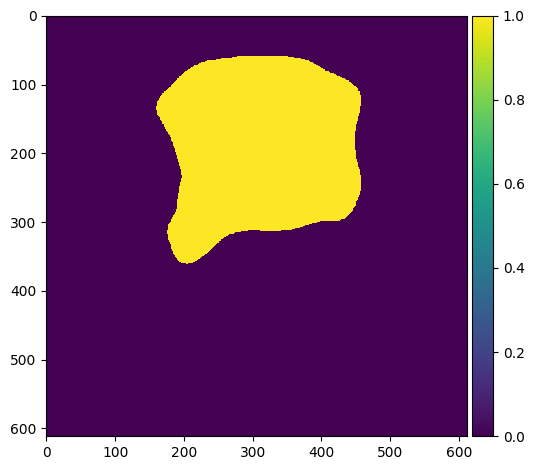

Threshold:  0.8
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_06.czi
Green Channel


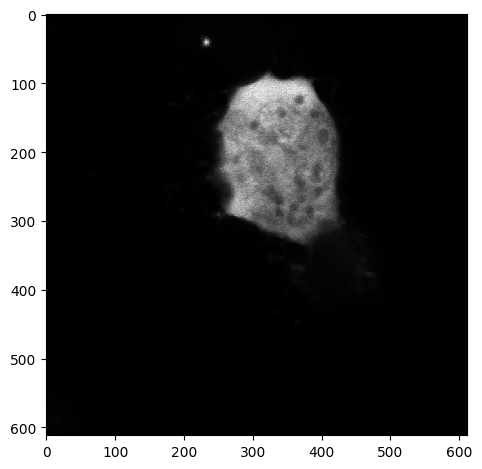

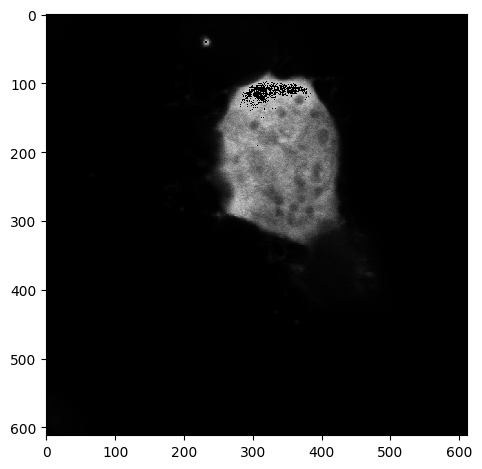

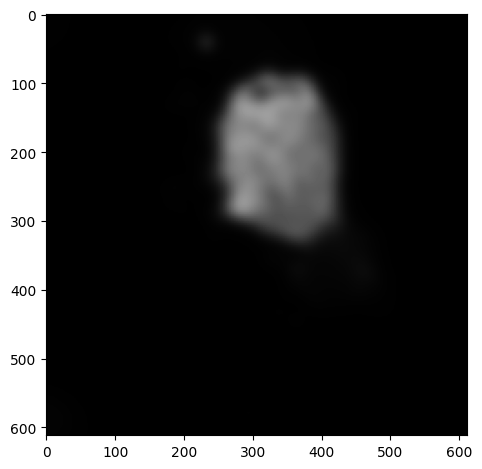

Segmented Cells


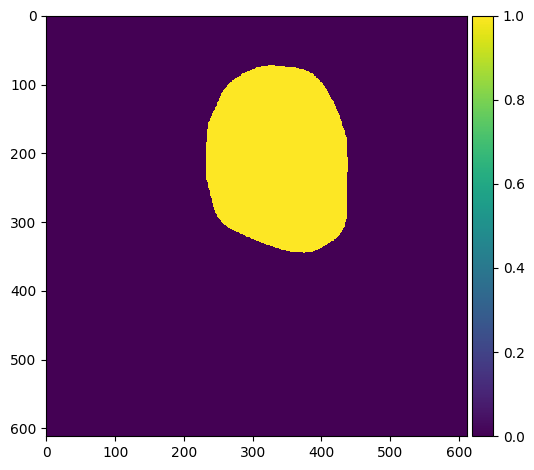

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_07.czi
Green Channel


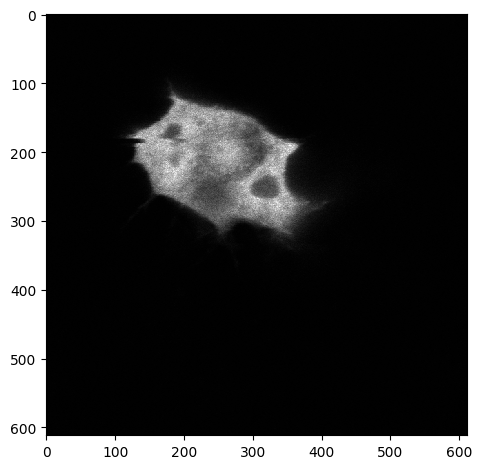

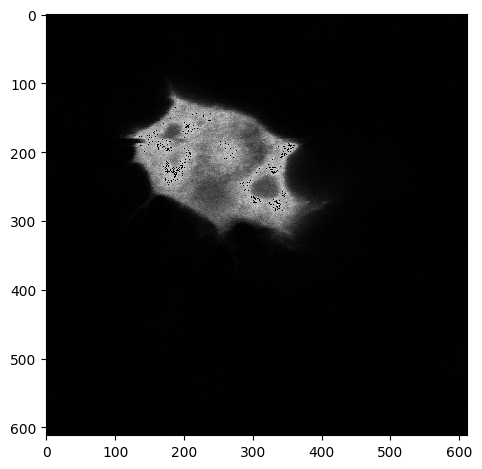

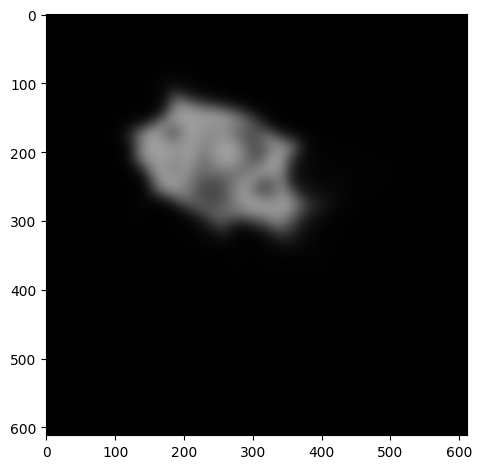

Segmented Cells


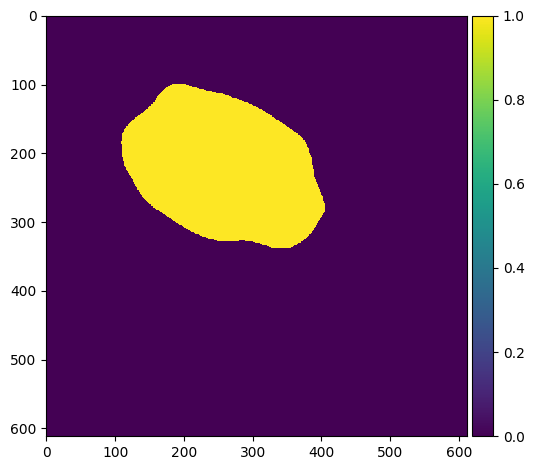

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_08.czi
Green Channel


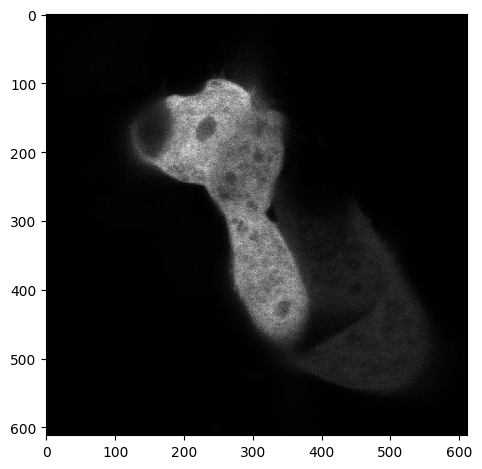

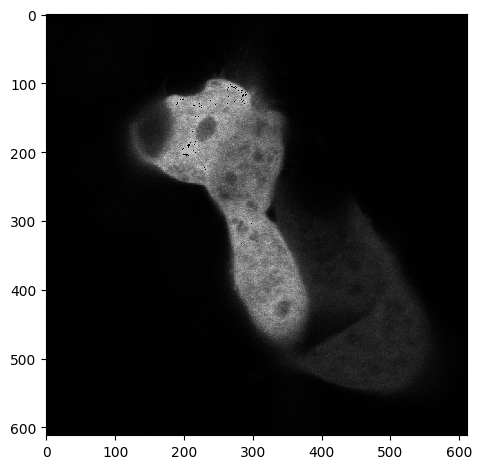

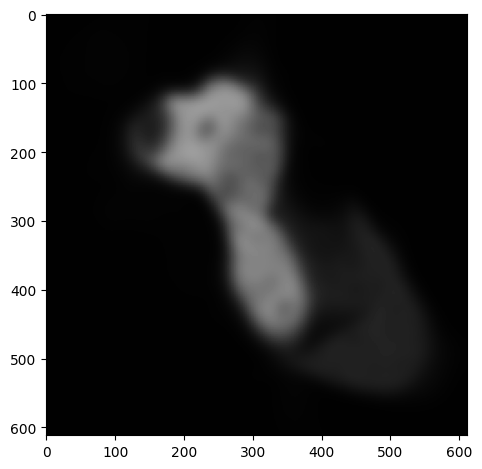

Segmented Cells


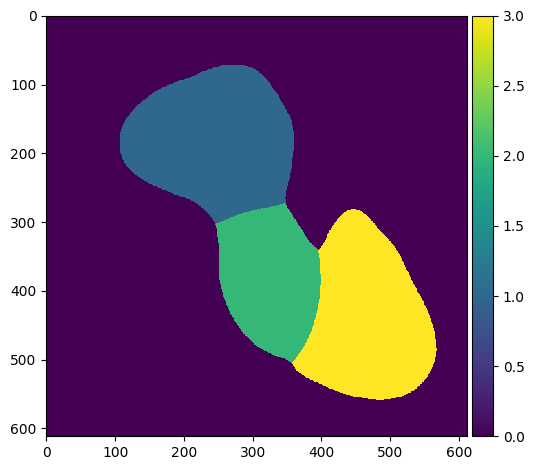

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_09.czi
Green Channel


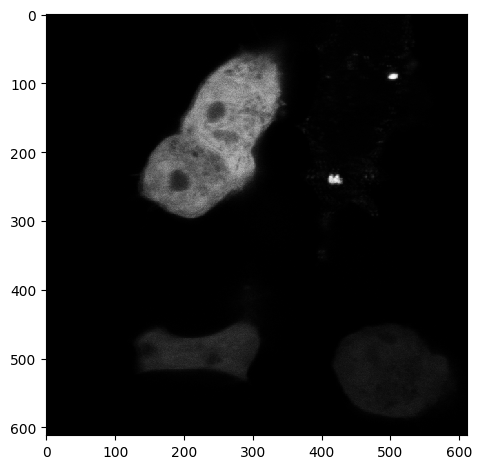

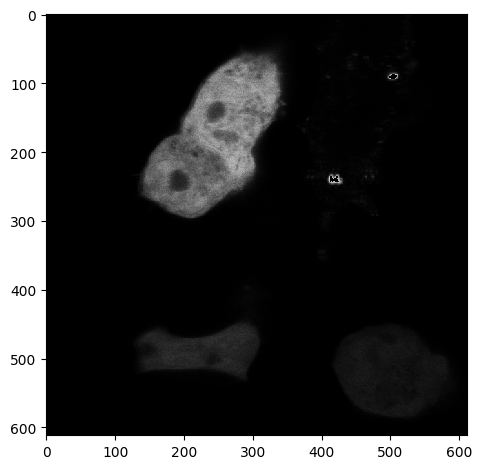

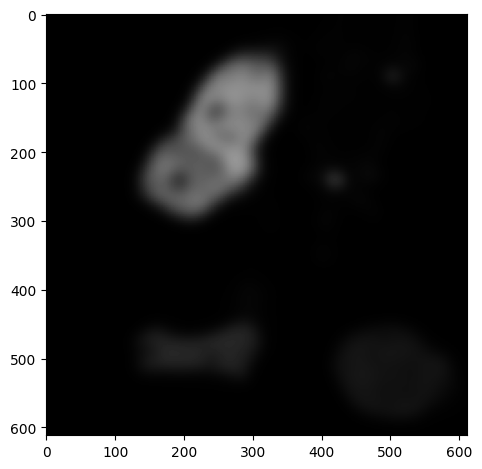

Segmented Cells


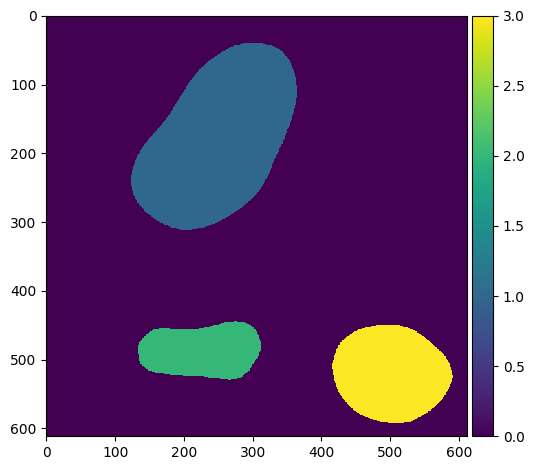

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1K_TAX1BP1_10.czi
Green Channel


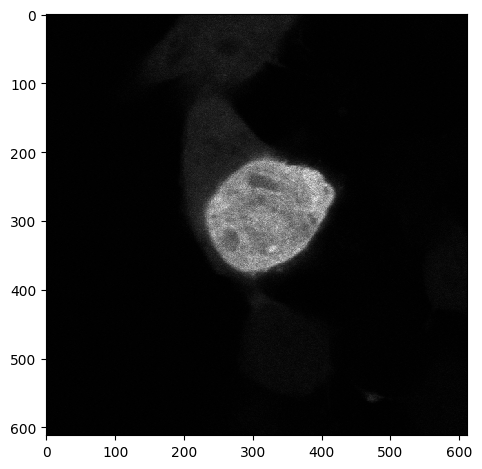

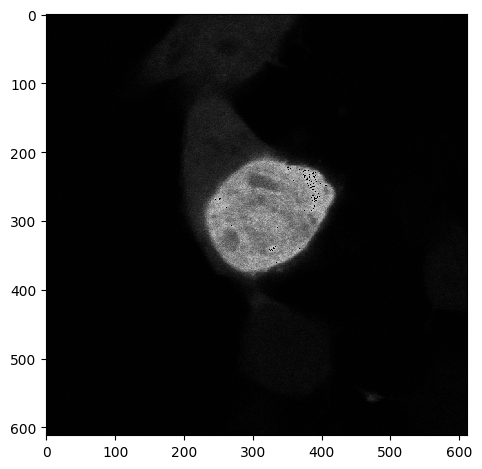

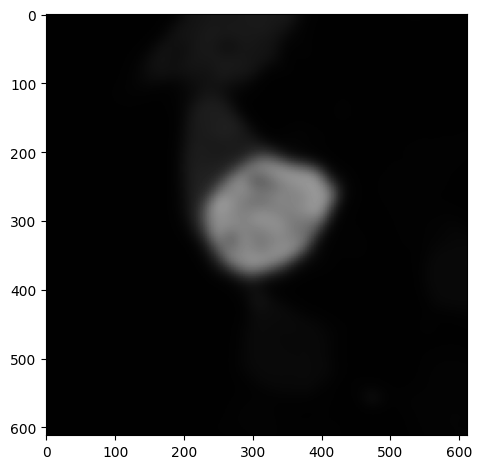

Segmented Cells


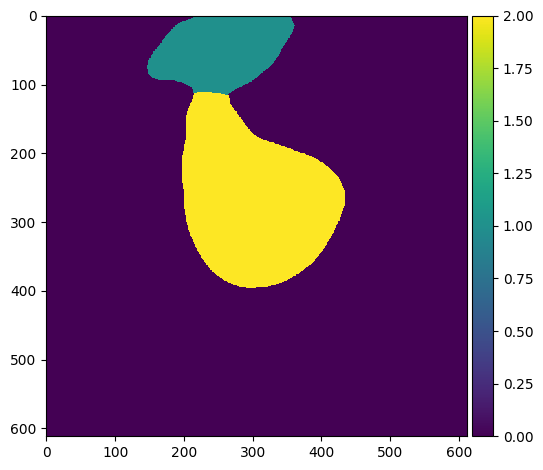

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_01.czi
Green Channel


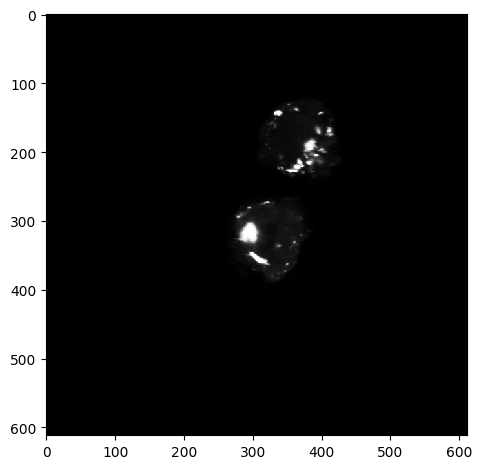

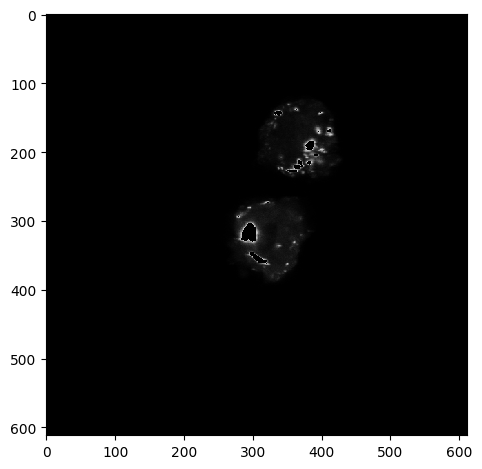

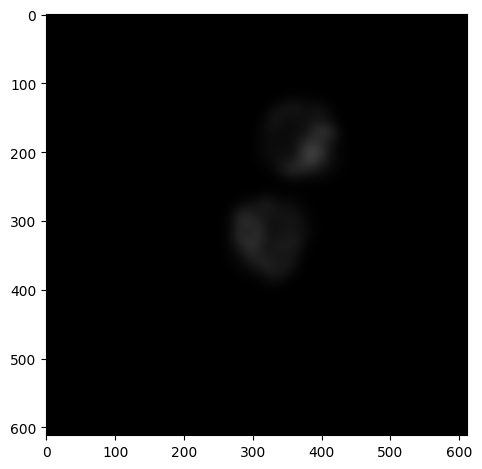

Segmented Cells


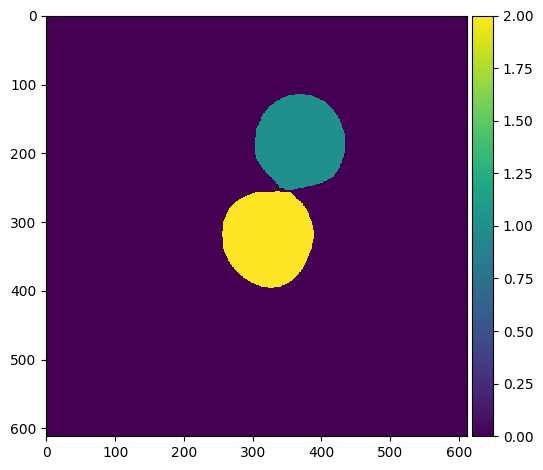

Threshold:  0.8
Inclusion Areas:  [ 58.  20. 129.  16.  93.  25.  42.]


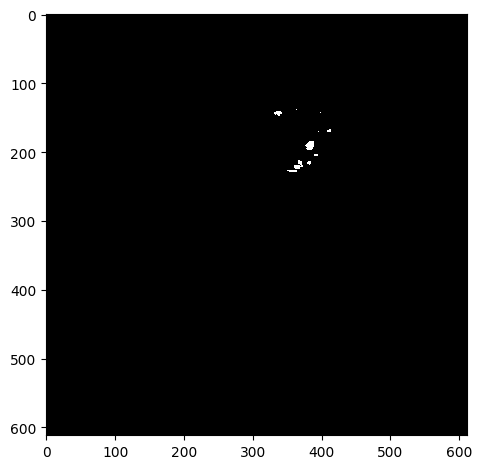

Threshold:  0.8
Inclusion Areas:  [437. 158.]


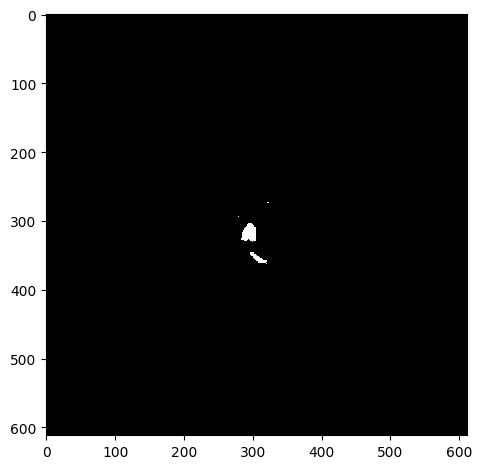

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_02.czi
Green Channel


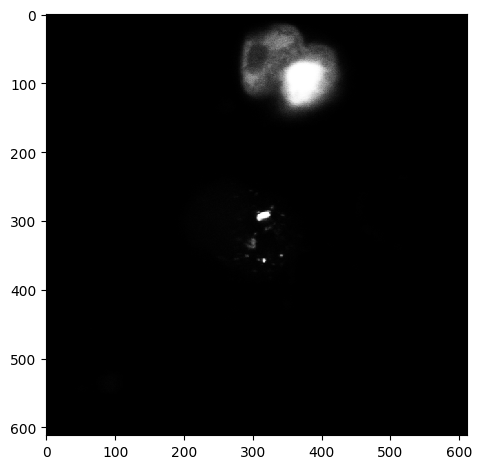

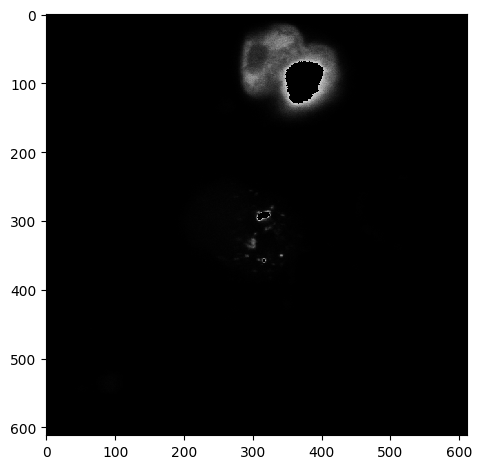

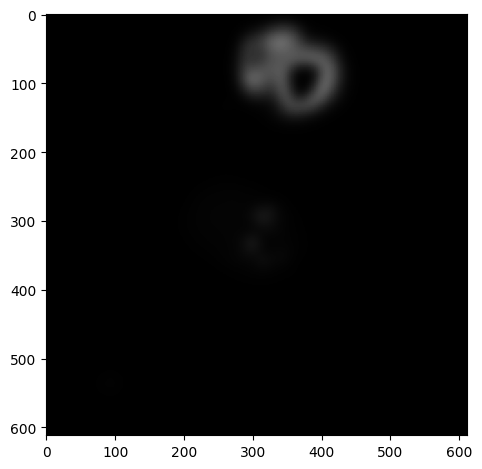

Segmented Cells


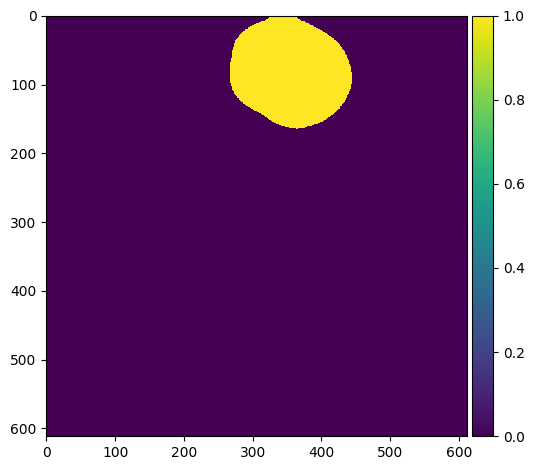

Threshold:  0.8
Inclusion Areas:  [2536.]


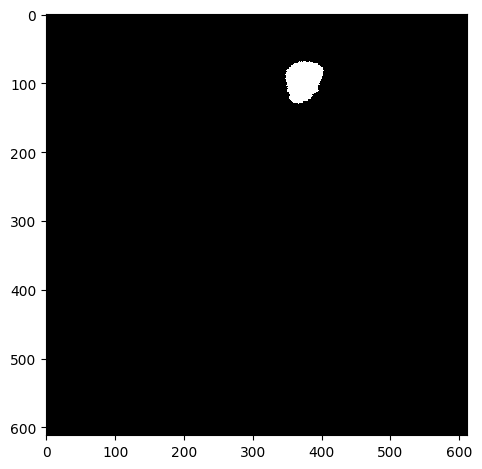

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_03.czi
Green Channel


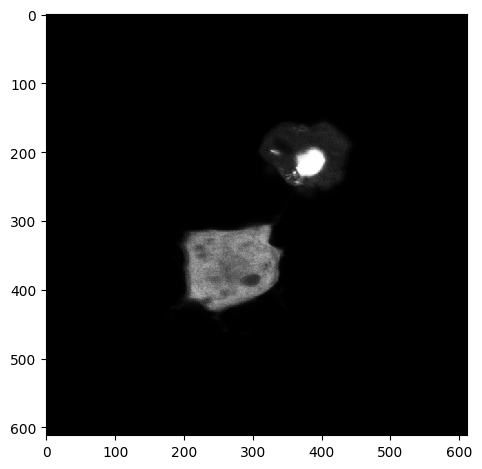

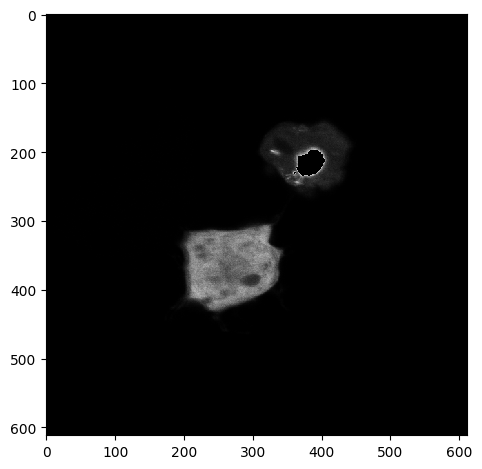

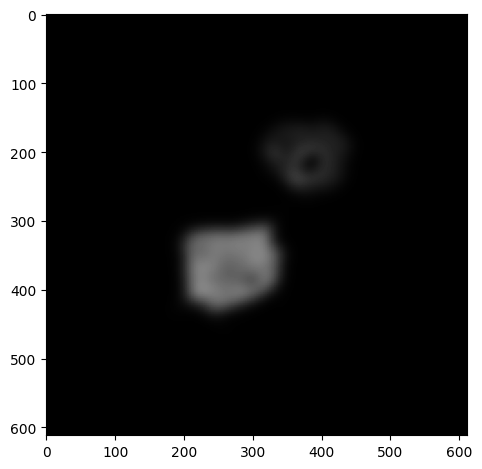

Segmented Cells


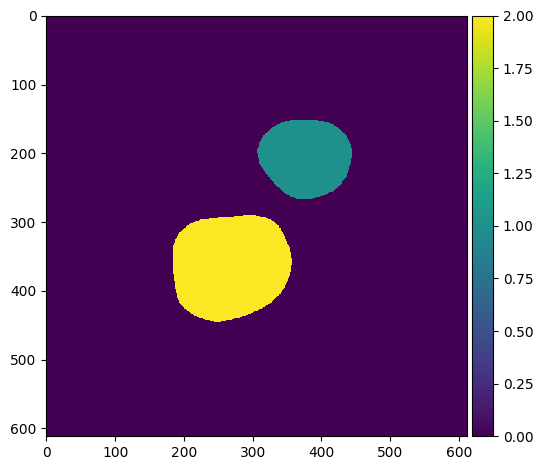

Threshold:  0.8
Inclusion Areas:  [1094.]


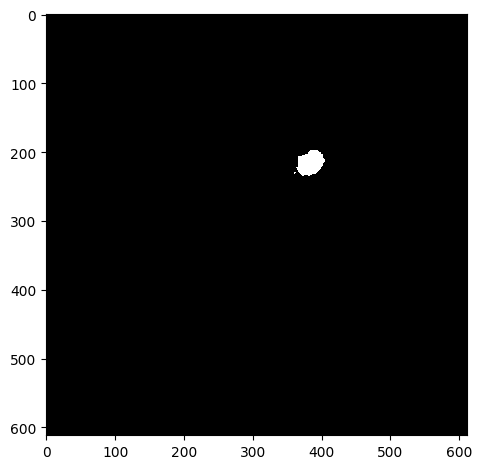

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_04.czi
Green Channel


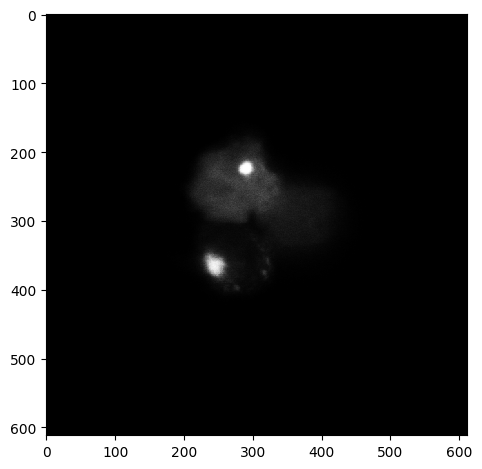

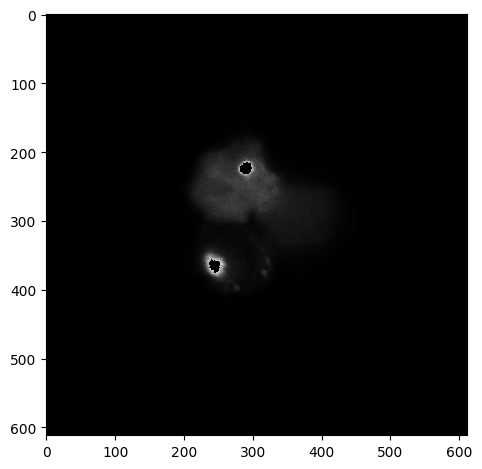

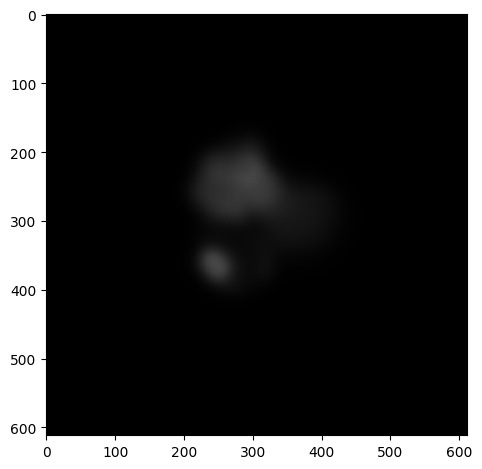

Segmented Cells


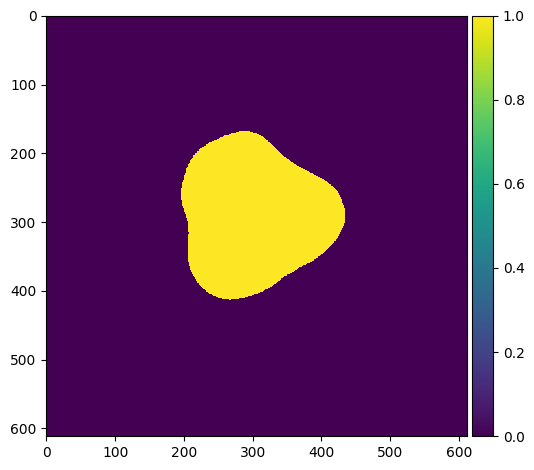

Threshold:  0.8
Inclusion Areas:  [234. 225.]


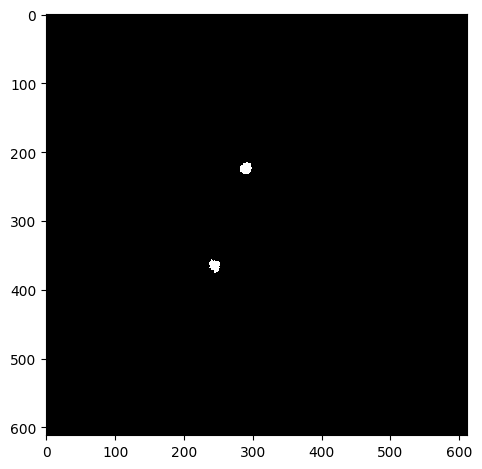

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_05.czi
Green Channel


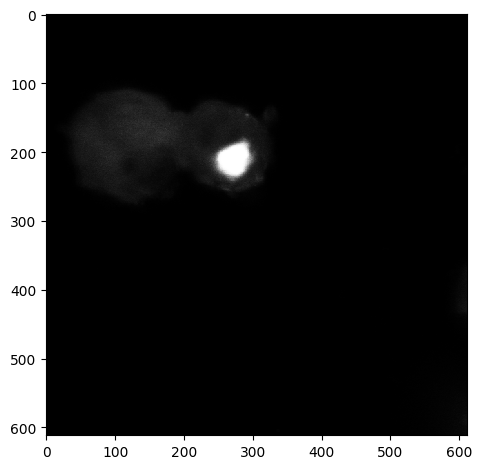

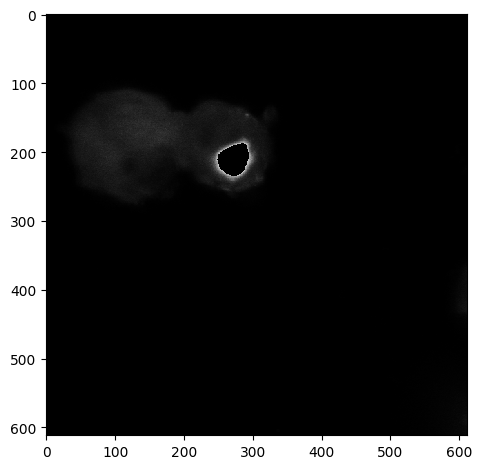

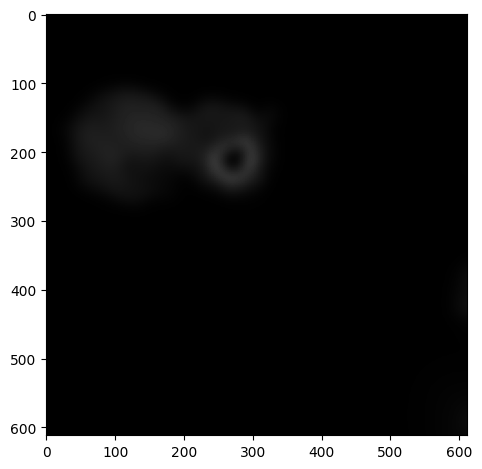

Segmented Cells


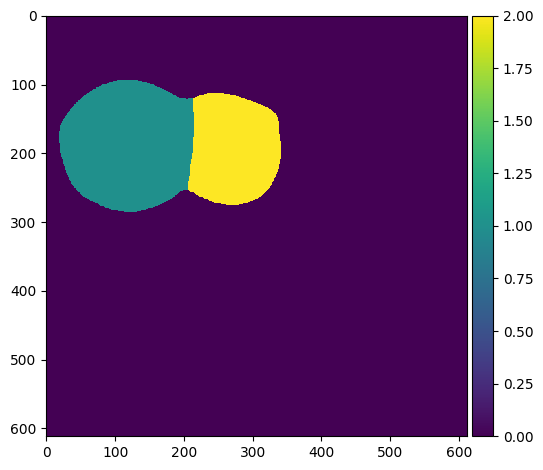

Threshold:  0.8
Inclusion Areas:  [1576.]


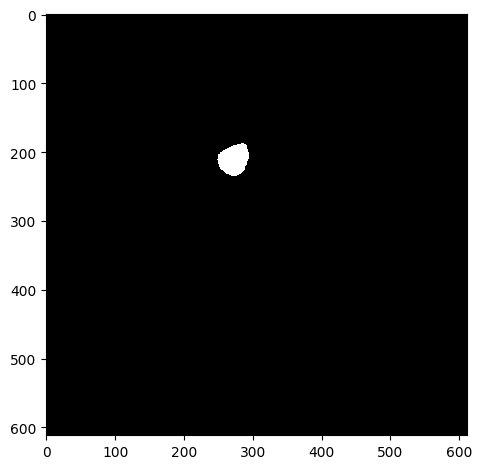

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_067.czi
Green Channel


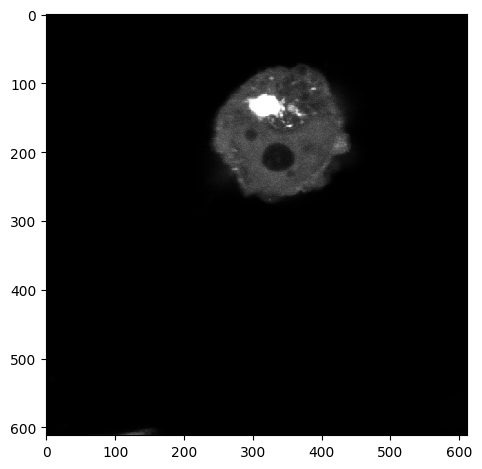

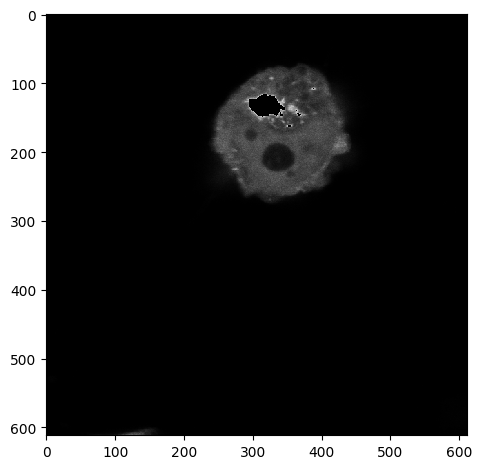

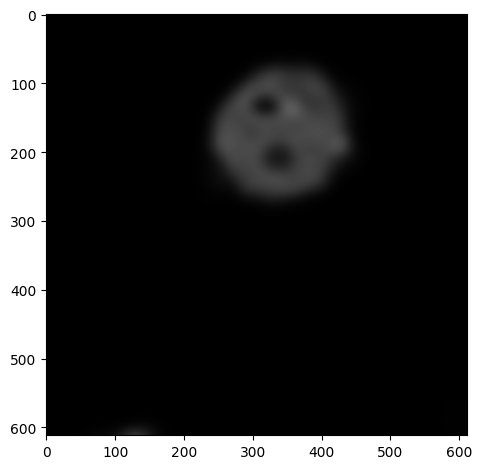

Segmented Cells


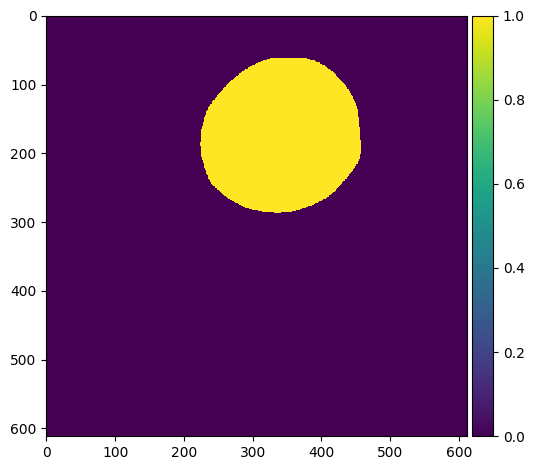

Threshold:  0.8
Inclusion Areas:  [1147.   15.   12.]


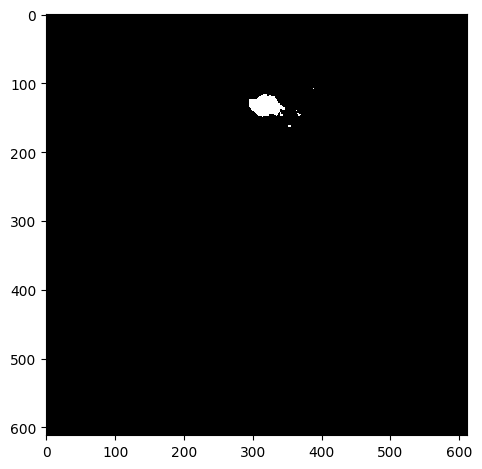

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_07.czi
Green Channel


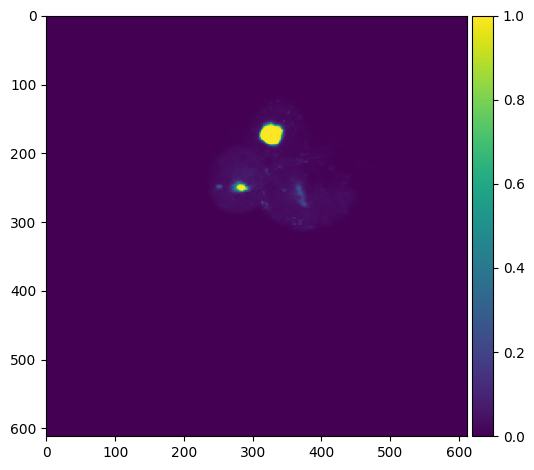

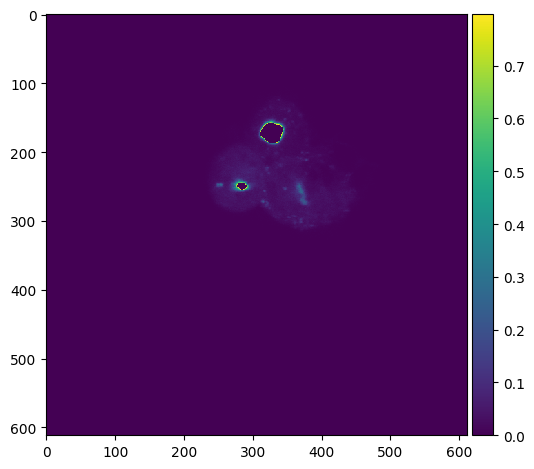

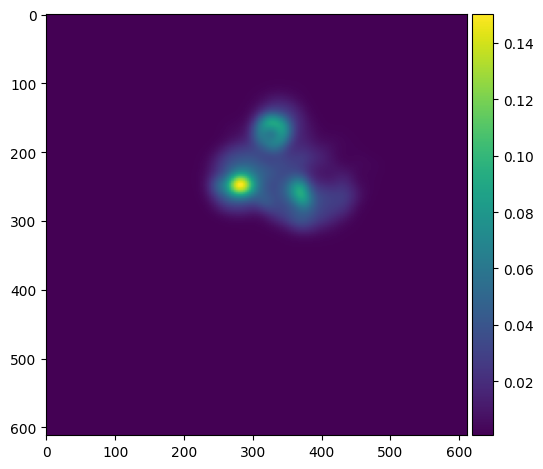

Segmented Cells


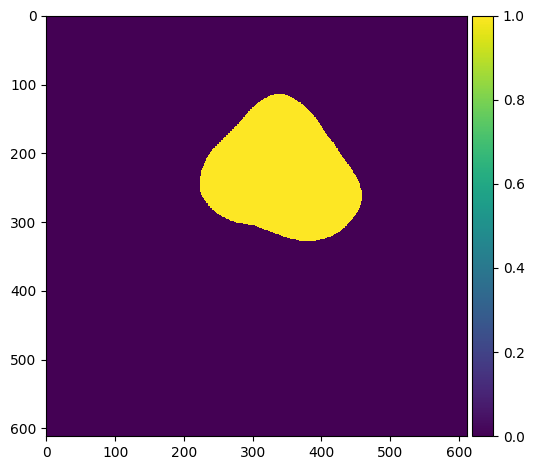

Threshold:  0.8
Inclusion Areas:  [705.  96.]


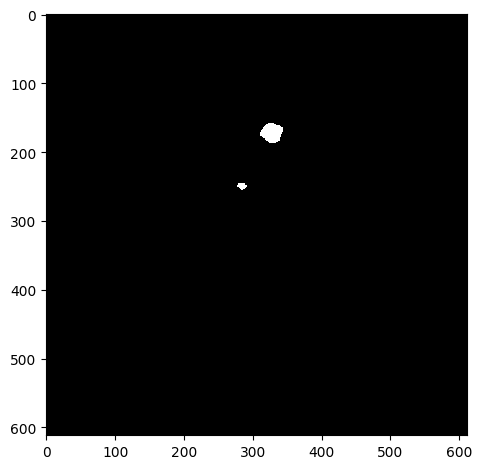

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_08.czi
Green Channel


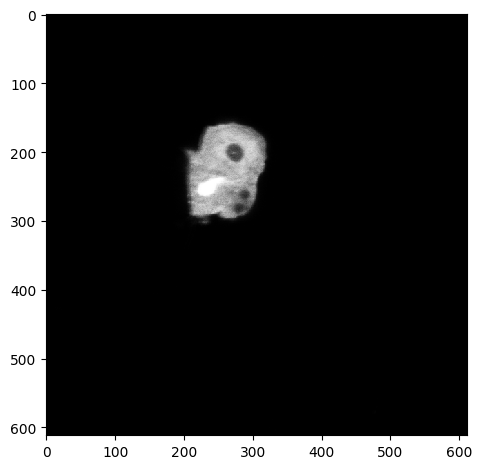

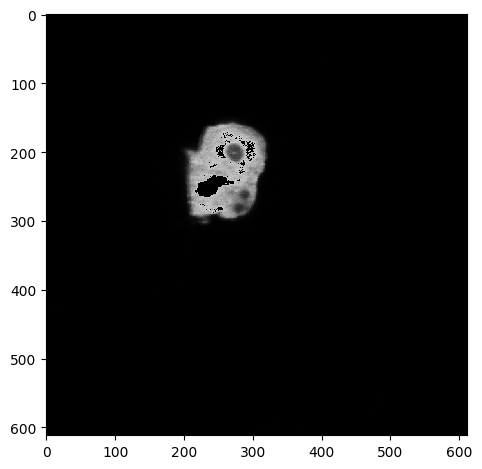

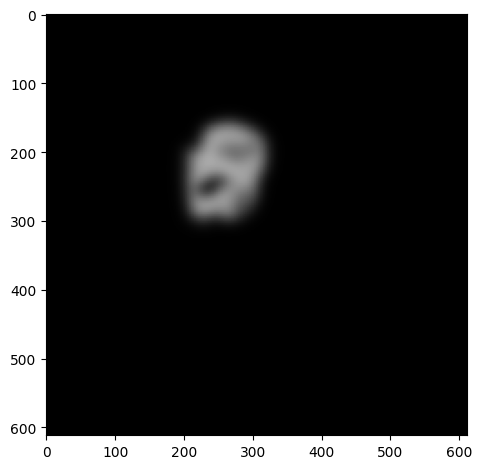

Segmented Cells


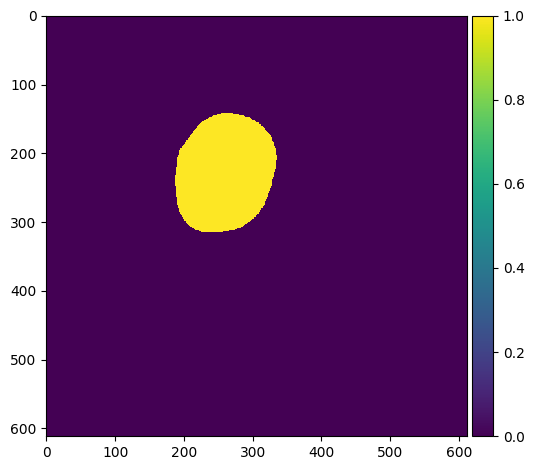

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_09.czi
Green Channel


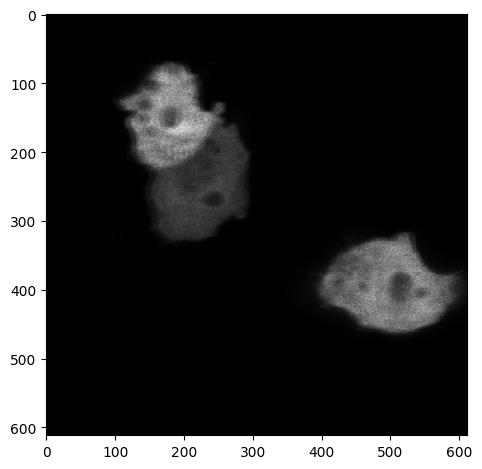

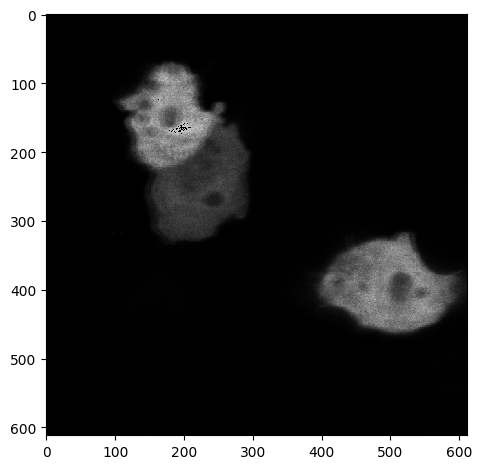

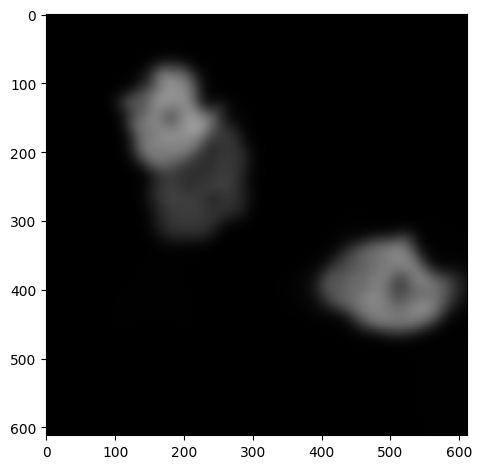

Segmented Cells


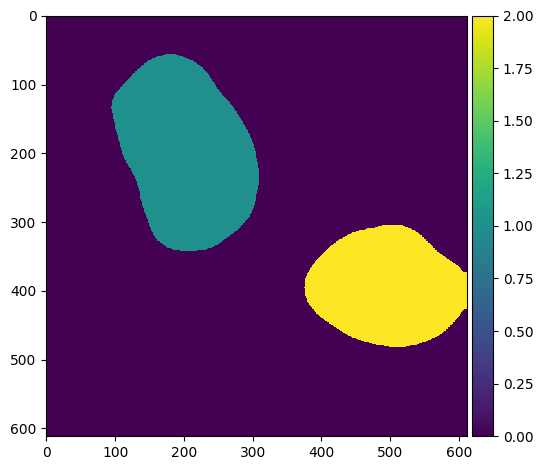

Threshold:  0.8
Inclusion Areas:  [52.]


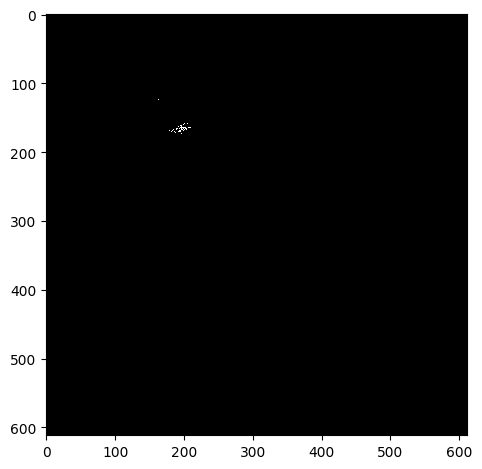

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
WT_ADAMTS19_10.czi
Green Channel


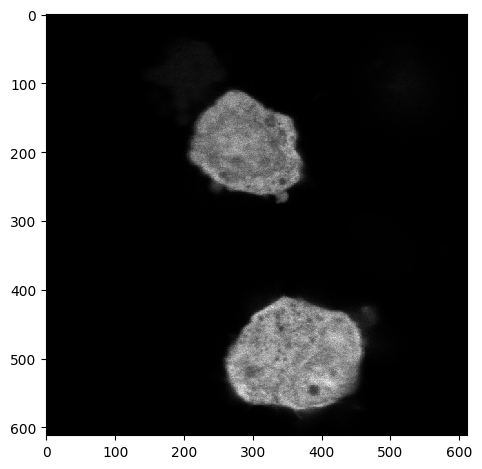

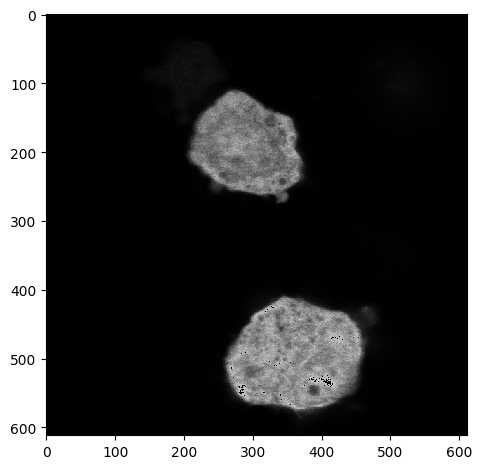

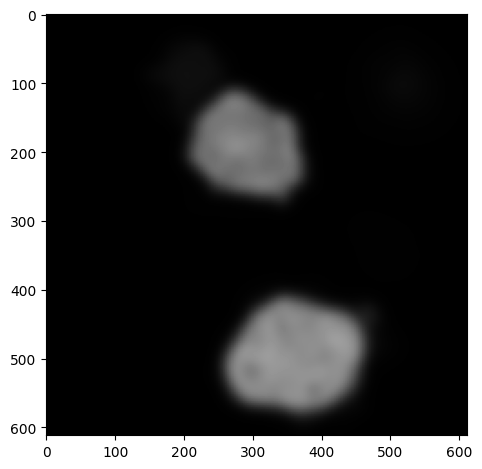

In [ ]:
if __name__ == "__main__":
    folders = ['011124_PFF_SCR_TAX_ADAM/new settings', '251024_PFF_SCR_TAX_ADAM', '281024_PFF_SCR_TAX_ADAM_800/new new settings','291024_PFF_SCR_TAX_ADAM_780']
    analyze_all_images(folders[1])
    # for folder in folders:
    #     analyze_all_images(folder)
